### Библиотеки

In [111]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_1samp
from statsmodels.graphics.tsaplots import plot_acf
import itertools
import requests
import optuna
import logging
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sqlite3


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
warnings.simplefilter("ignore")
logger = logging.getLogger("optuna")
logger.setLevel(logging.WARNING)

## База данных (sqlite3)

### Создание базы данных

#### Функции

In [112]:
# Инициализация базы данных и создание таблиц
def init_db():
    conn = sqlite3.connect('moex_stock_price_prediction_service.db')
    cursor = conn.cursor()
    
    # ТАБЛИЦА ЦЕН
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS prices (
        SECID TEXT,
        TRADEDATE TEXT,
        WAPRICE REAL,
        OPEN REAL,
        CLOSE REAL,
        LOW REAL,
        HIGH REAL,
        VOLUME INTEGER,
        PRIMARY KEY (SECID, TRADEDATE)
    )
    ''')
    

    # ТАБЛИЦА ДИВИДЕНДОВ
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS dividends (
        secid TEXT,
        isin TEXT,
        registryclosedate TEXT,
        value REAL,
        currencyid TEXT,
        PRIMARY KEY (secid, registryclosedate)
    )
    ''')
    

    # ТАБЛИЦА СПЛИТОВ
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS splits (
        tradedate TEXT,
        secid TEXT,
        before INTEGER,
        after INTEGER,
        PRIMARY KEY (secid, tradedate)
    )
    ''')
    
    conn.commit()
    conn.close()


# ОБНОВЛЕНИЕ ТАБЛИЦЫ
def update_table(conn, df, table_name):
    """Обновляет таблицу, игнорируя дубликаты"""
    if df.empty:
        return
        
    # Создаем временную таблицу
    df.to_sql('temp_table', conn, if_exists='replace', index=False)
    
    # Вставляем данные, игнорируя дубликаты
    cursor = conn.cursor()
    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    
    cursor.execute(f"""
    INSERT OR IGNORE INTO {table_name} ({columns})
    SELECT {columns} FROM temp_table
    """)
    
    # Удаляем временную таблицу
    cursor.execute("DROP TABLE temp_table")
    conn.commit()


# ПАРСИНГ ЦЕН С MOEX
def fetch_prices_data(ticker, start_date, end_date, engine='stock', market='shares', board='TQBR'):
    url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{ticker}.json"
    all_data = []
    start = 0
    expected_columns = ['SECID', 'TRADEDATE', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME']

    while True:
        params = {'from': start_date, 'till': end_date, 'start': start}
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Ошибка для {ticker}: {response.status_code}")
            break

        json_data = response.json()
        history = json_data.get('history', {})
        data = history.get('data', [])

        if not data:
            break

        df = pd.DataFrame(data, columns=history.get('columns', []))
        df = df.reindex(columns=expected_columns).dropna(how='all')

        if not df.empty:
            all_data.append(df)
            start += len(data)
        else:
            break

    if all_data:
        dtypes = {
            'SECID': 'str',
            'TRADEDATE': 'str',
            'WAPRICE': 'float64',
            'OPEN': 'float64',
            'CLOSE': 'float64',
            'LOW': 'float64',
            'HIGH': 'float64',
            'VOLUME': 'int64'
        }
        return pd.concat(all_data, ignore_index=True).astype(dtypes)
    return pd.DataFrame()


# ПАРСИНГ ДИВИДЕНДОВ С MOEX
def fetch_dividends_data(ticker):
    url = f"https://iss.moex.com/iss/securities/{ticker}/dividends.json"
    
    params = {
        'iss.json': 'extended',
        'iss.meta': 'off'
    }
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Ошибка для {ticker}: {response.status_code}")
        return pd.DataFrame()

    data = response.json()[1].get('dividends', [])
    if not data:
        return pd.DataFrame()

    expected_columns = ['secid', 'isin', 'registryclosedate', 'value', 'currencyid']
    df = pd.DataFrame(data).reindex(columns=expected_columns)
    
    dtypes = {
        'secid': 'str',
        'isin': 'str',
        'registryclosedate': 'str',
        'value': 'float64',
        'currencyid': 'str'
    }
    return df.astype(dtypes)


# ПАРСИНГ СПЛИТОВ С MOEX
def fetch_splits_data(engine='stock'):
    url = f"https://iss.moex.com/iss/statistics/engines/{engine}/splits.json"
    
    params = {
        'iss.json': 'extended',
        'iss.meta': 'off'
    }
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Ошибка при получении сплитов: {response.status_code}")
        return pd.DataFrame()

    data = response.json()[1].get('splits', [])
    if not data:
        return pd.DataFrame()

    expected_columns = ['tradedate', 'secid', 'before', 'after']
    df = pd.DataFrame(data).reindex(columns=expected_columns)
    
    dtypes = {
        'tradedate': 'str',
        'secid': 'str',
        'before': 'int32',
        'after': 'int32'
    }
    return df.astype(dtypes)


def get_last_date_by_ticker(ticker):
    conn = sqlite3.connect('moex_stock_price_prediction_service.db')
    query = f"SELECT MAX(TRADEDATE) FROM prices WHERE SECID = '{ticker}'"
    last_date = pd.read_sql(query, conn).iloc[0, 0]
    conn.close()
    return last_date if last_date else '2022-04-01'

#### Запуск парсинга и добавления в БД

In [113]:
# Инициализация БД
init_db()

# Подключаемся к БД
conn = sqlite3.connect('moex_stock_price_prediction_service.db')

try:
    # Список тикеров
    tickers = [
        'AFKS', 'AFLT', 'ALRS', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FEES',
        'FLOT', 'GAZP', 'GMKN', 'HYDR', 'IRAO', 'LKOH', 'MAGN',
        'MGNT', 'MOEX', 'MSNG', 'MTLR', 'MTLRP', 'MTSS', 'NLMK', 'NVTK', 'PHOR',
        'PIKK', 'PLZL', 'POSI', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SBERP', 'SELG',
        'SMLT', 'SNGS', 'SNGSP', 'T', 'TATN', 'TATNP', 'TRNFP', 
        'UPRO', 'VKCO', 'VTBR', 'YDEX', 'YNDX', 'TCSG'
    ]
    
    # Парсим и обновляем цены
    print("Обновление данных по ценам...")

    end_date = datetime.now().strftime('%Y-%m-%d')
    for ticker in tqdm(tickers):    
        start_date = get_last_date_by_ticker(ticker)

        price_data = fetch_prices_data(ticker, start_date, end_date)
        if not price_data.empty:
            update_table(conn, price_data, 'prices')
    

    # Парсим и обновляем дивиденды
    print("Обновление данных по дивидендам...")
    for ticker in tqdm(tickers):
        div_data = fetch_dividends_data(ticker)
        if not div_data.empty:
            update_table(conn, div_data, 'dividends')
    

    # Парсим сплиты
    print("Обновление данных по сплитам...")
    splits_data = fetch_splits_data()
    if not splits_data.empty:
        update_table(conn, splits_data, 'splits')
        
    print("✅ Все данные успешно обновлены!")
    
finally:
    conn.close()

Обновление данных по ценам...


100%|██████████| 46/46 [00:06<00:00,  7.58it/s]


Обновление данных по дивидендам...


100%|██████████| 46/46 [00:02<00:00, 18.62it/s]


Обновление данных по сплитам...
✅ Все данные успешно обновлены!


## Обработка

### Перевод в pd.DataFrame

#### Prices

In [114]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    data = pd.read_sql('SELECT * FROM prices', conn)

print(f'data.shape = {data.shape}')
print(f'columns = {data.columns}')

data.shape = (35202, 8)
columns = Index(['SECID', 'TRADEDATE', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH',
       'VOLUME'],
      dtype='object')


#### Dividends

In [115]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    data_dividends = pd.read_sql('SELECT * FROM dividends', conn)

print(f'data.shape = {data_dividends.shape}')
print(f'columns = {data_dividends.columns}')

data.shape = (481, 5)
columns = Index(['secid', 'isin', 'registryclosedate', 'value', 'currencyid'], dtype='object')


#### Splits

In [116]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    results_splits = pd.read_sql('SELECT * FROM splits', conn)

print(f'data.shape = {results_splits.shape}')
print(f'columns = {results_splits.columns}')

data.shape = (48, 4)
columns = Index(['tradedate', 'secid', 'before', 'after'], dtype='object')


### Сохраняем сырые DataFrame в CSV

In [117]:
data.to_csv('raw_data.csv', index=False)

data_dividends.to_csv('dividends_data.csv', index=False)

results_splits.to_csv('splits_data.csv', index=False)

### Приводим к одному индексу

In [118]:
full_idxs = data['TRADEDATE'].unique()
df = pd.DataFrame(data=full_idxs,
                  columns=['TRADEDATE'])

tickers_series = pd.Series(tickers, name='SECID')

df = df.merge(tickers_series, how='cross')

df = df.merge(data, 
              how='left', 
              left_on=['TRADEDATE', 'SECID'], 
              right_on=['TRADEDATE', 'SECID']).sort_values(by=['SECID', 'TRADEDATE'])

df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], format='%Y-%m-%d')

df.set_index('TRADEDATE', inplace=True)

df

,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
TRADEDATE,,,,,,,
2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...
2025-05-21,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-22,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-23,YNDX,NaN,NaN,NaN,NaN,NaN,NaN


### Проверка данных

In [119]:
df

,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
TRADEDATE,,,,,,,
2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...
2025-05-21,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-22,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-23,YNDX,NaN,NaN,NaN,NaN,NaN,NaN


#### Пропуски

In [120]:
list_of_tickers_with_gaps = df.groupby('SECID')['WAPRICE'].apply(lambda x: x.isna().sum()).sort_values(ascending=False)
list_of_tickers_with_gaps

SECID
T        676
YDEX     585
YNDX     242
TCSG     143
VKCO      23
FEES      12
GMKN       4
TRNFP      4
PLZL       3
VTBR       2
TATNP      0
TATN       0
PIKK       0
UPRO       0
SNGS       0
SMLT       0
SELG       0
SBERP      0
SBER       0
RUAL       0
RTKM       0
ROSN       0
POSI       0
SNGSP      0
AFKS       0
AFLT       0
IRAO       0
ALRS       0
BSPB       0
CBOM       0
CHMF       0
ENPG       0
FLOT       0
GAZP       0
HYDR       0
LKOH       0
NVTK       0
MAGN       0
MGNT       0
MOEX       0
MSNG       0
MTLR       0
MTLRP      0
MTSS       0
NLMK       0
PHOR       0
Name: WAPRICE, dtype: int64

**Решение:**

- Т-Банк менял тикер с TCSG на T. Соединим данные по этим тикерам
- Яндекс менял тикер с YNDX на YDEX. Соединим данные по этим тикерам

Недавно допущены к торгам: 
- LEAS
- HEAD 
- SVCB
- LEAS 

Пока для простоты их отбросим. В будущей версии сервиса научимся их обрабатывать.



##### Объединяем котировки для разных тикеров Яндекса и Т

In [121]:
def merge_series(df, prev_ticket, cur_ticket):
    """
    Объединяет два pd.Series, заполняя NaN значения из другой Series.
    
    Parameters:
    -----------
    prev_series : pd.Series
        Первая Series с индексом 'TRADEDATE'
    cur_series : pd.Series
        Вторая Series с индексом 'TRADEDATE'
    
    Returns:
    --------
    pd.Series
        Объединенная Series, где NaN значения заполнены из другой Series,
        если в другой Series по той же дате есть не-NaN значение.
    """
    prev_series = df.loc[df['SECID'] == prev_ticket]
    cur_series = df.loc[df['SECID'] == cur_ticket]
    
    # Создаем объединенный индекс, чтобы включить все возможные даты из обеих Series
    combined_index = prev_series.index.union(cur_series.index)
    
    # Переиндексируем обе Series для использования общего индекса
    prev_reindexed = prev_series.reindex(combined_index)
    cur_reindexed = cur_series.reindex(combined_index)
    
    # Создаем результирующую Series, где значения берутся из prev_series,
    # а если там NaN, то из cur_series
    result = cur_reindexed.fillna(prev_reindexed)
    
    return result


def merge_series_in_df(df, prev_ticket, cur_ticket):
    df_copy = df.copy()
    merged_series = merge_series(df, prev_ticket, cur_ticket)

    df_copy = df_copy[~( (df['SECID'] == prev_ticket) | (df['SECID'] == cur_ticket) )]
    
    df_copy = pd.concat([df_copy, merge_series(df, prev_ticket, cur_ticket)])
    
    return df_copy

In [122]:
# Яндекс
df = merge_series_in_df(df, 'YNDX', 'YDEX')

# ТБанк
df = merge_series_in_df(df, 'TCSG', 'T')

Проверяем новые пропуски

In [123]:
list_of_tickers_with_gaps = df.groupby('SECID')['WAPRICE'].apply(lambda x: x.isna().sum()).sort_values(ascending=False) 
list_of_tickers_with_gaps

SECID
YDEX     27
VKCO     23
T        19
FEES     12
TRNFP     4
GMKN      4
PLZL      3
VTBR      2
SBERP     0
POSI      0
ROSN      0
RTKM      0
RUAL      0
SBER      0
SNGSP     0
SELG      0
SMLT      0
SNGS      0
PHOR      0
TATN      0
TATNP     0
UPRO      0
PIKK      0
AFKS      0
AFLT      0
NLMK      0
ALRS      0
BSPB      0
CBOM      0
CHMF      0
ENPG      0
FLOT      0
GAZP      0
HYDR      0
IRAO      0
LKOH      0
MAGN      0
MGNT      0
MOEX      0
MSNG      0
MTLR      0
MTLRP     0
MTSS      0
NVTK      0
Name: WAPRICE, dtype: int64

##### Заполняем пропуски

Смотрим на котировки с пропусками

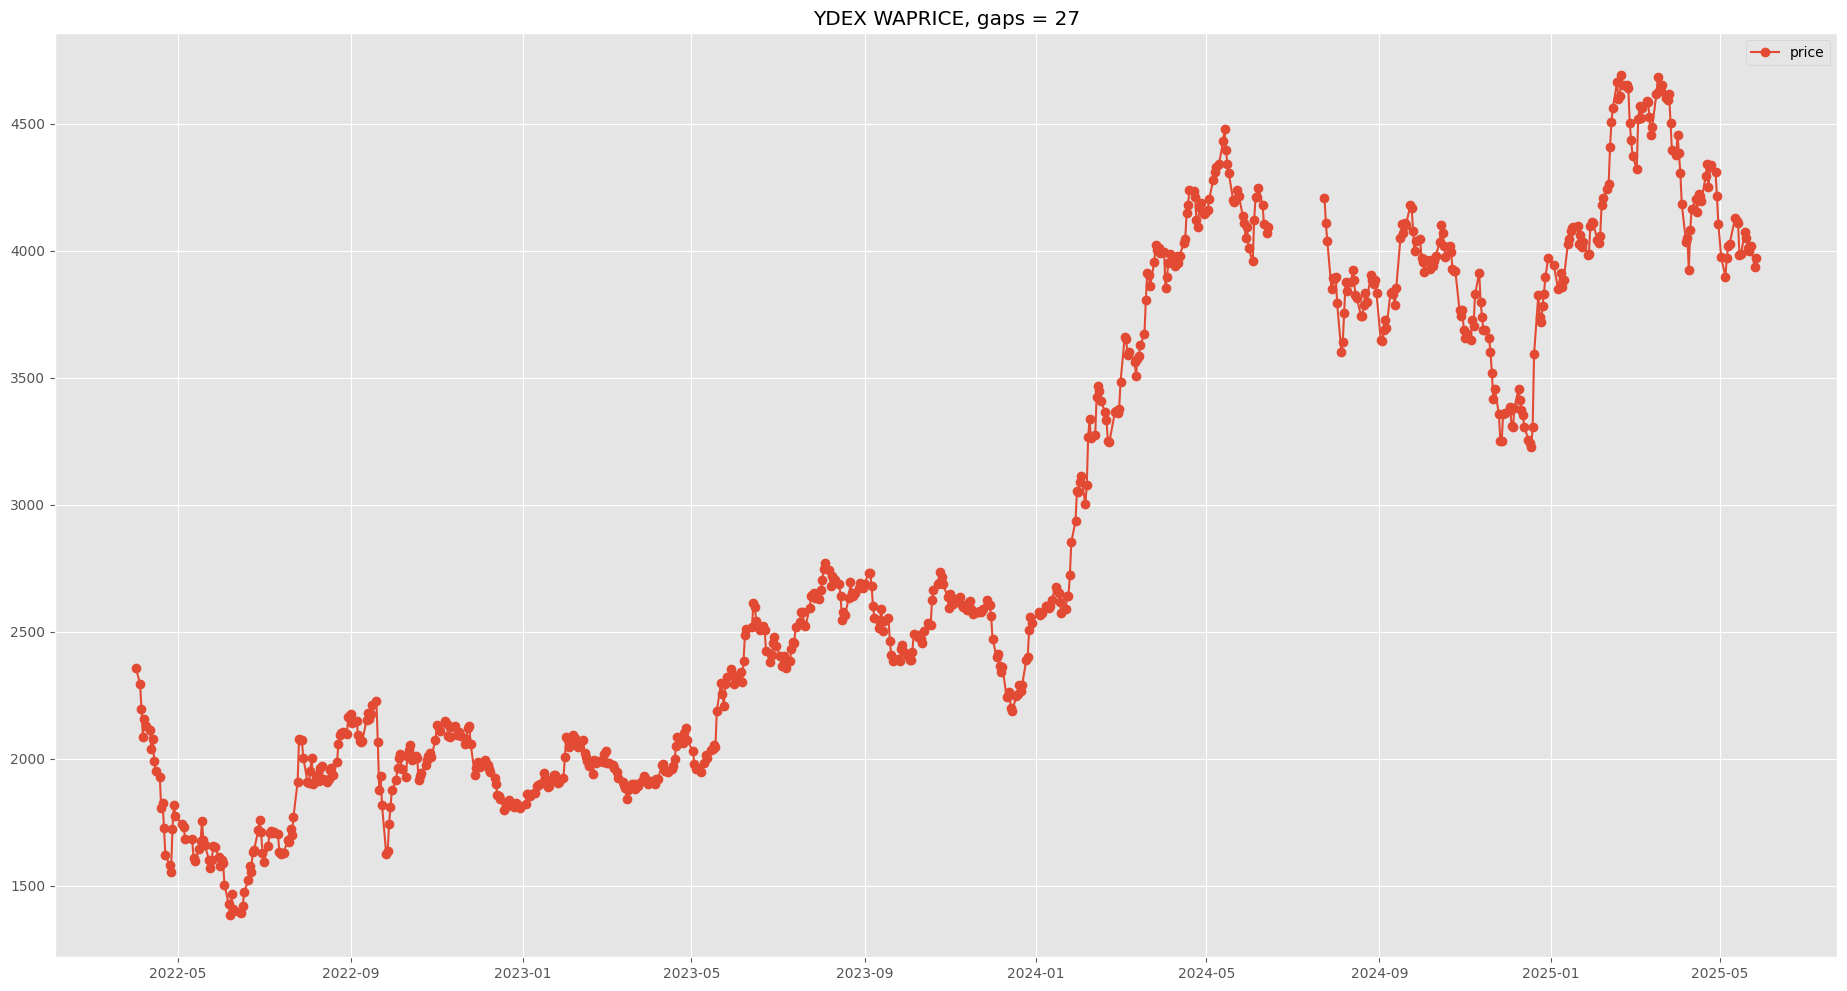

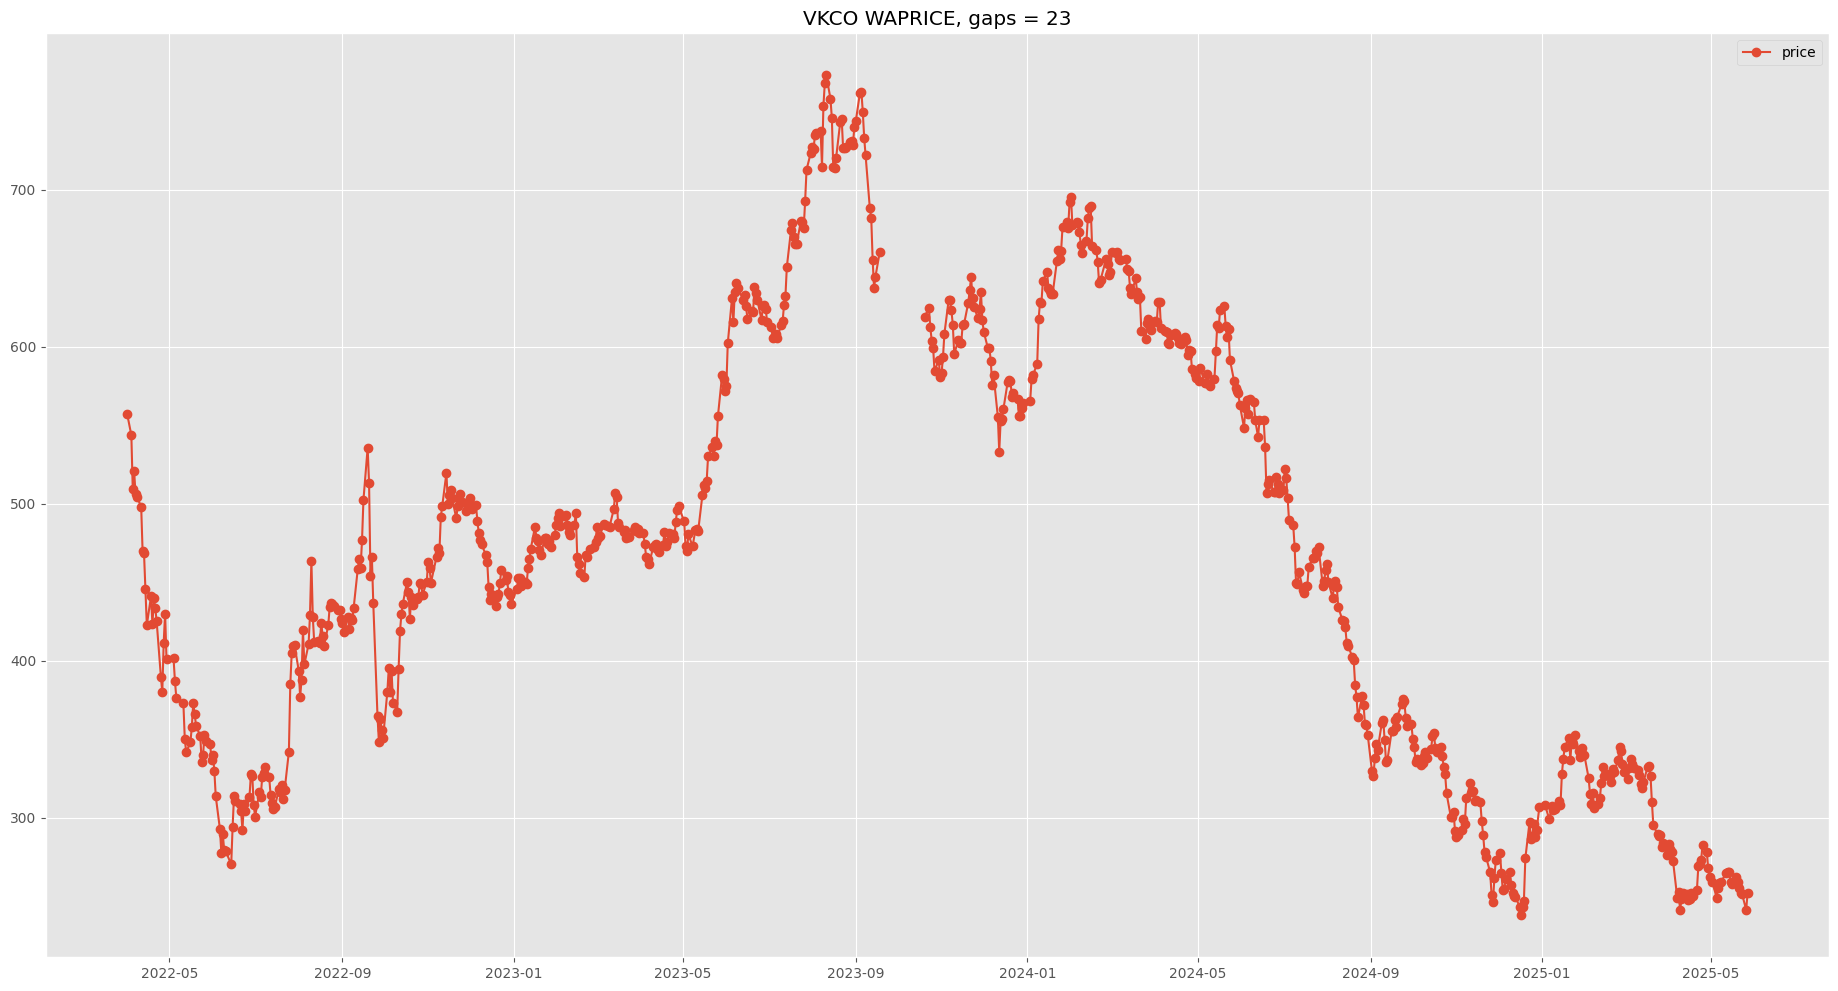

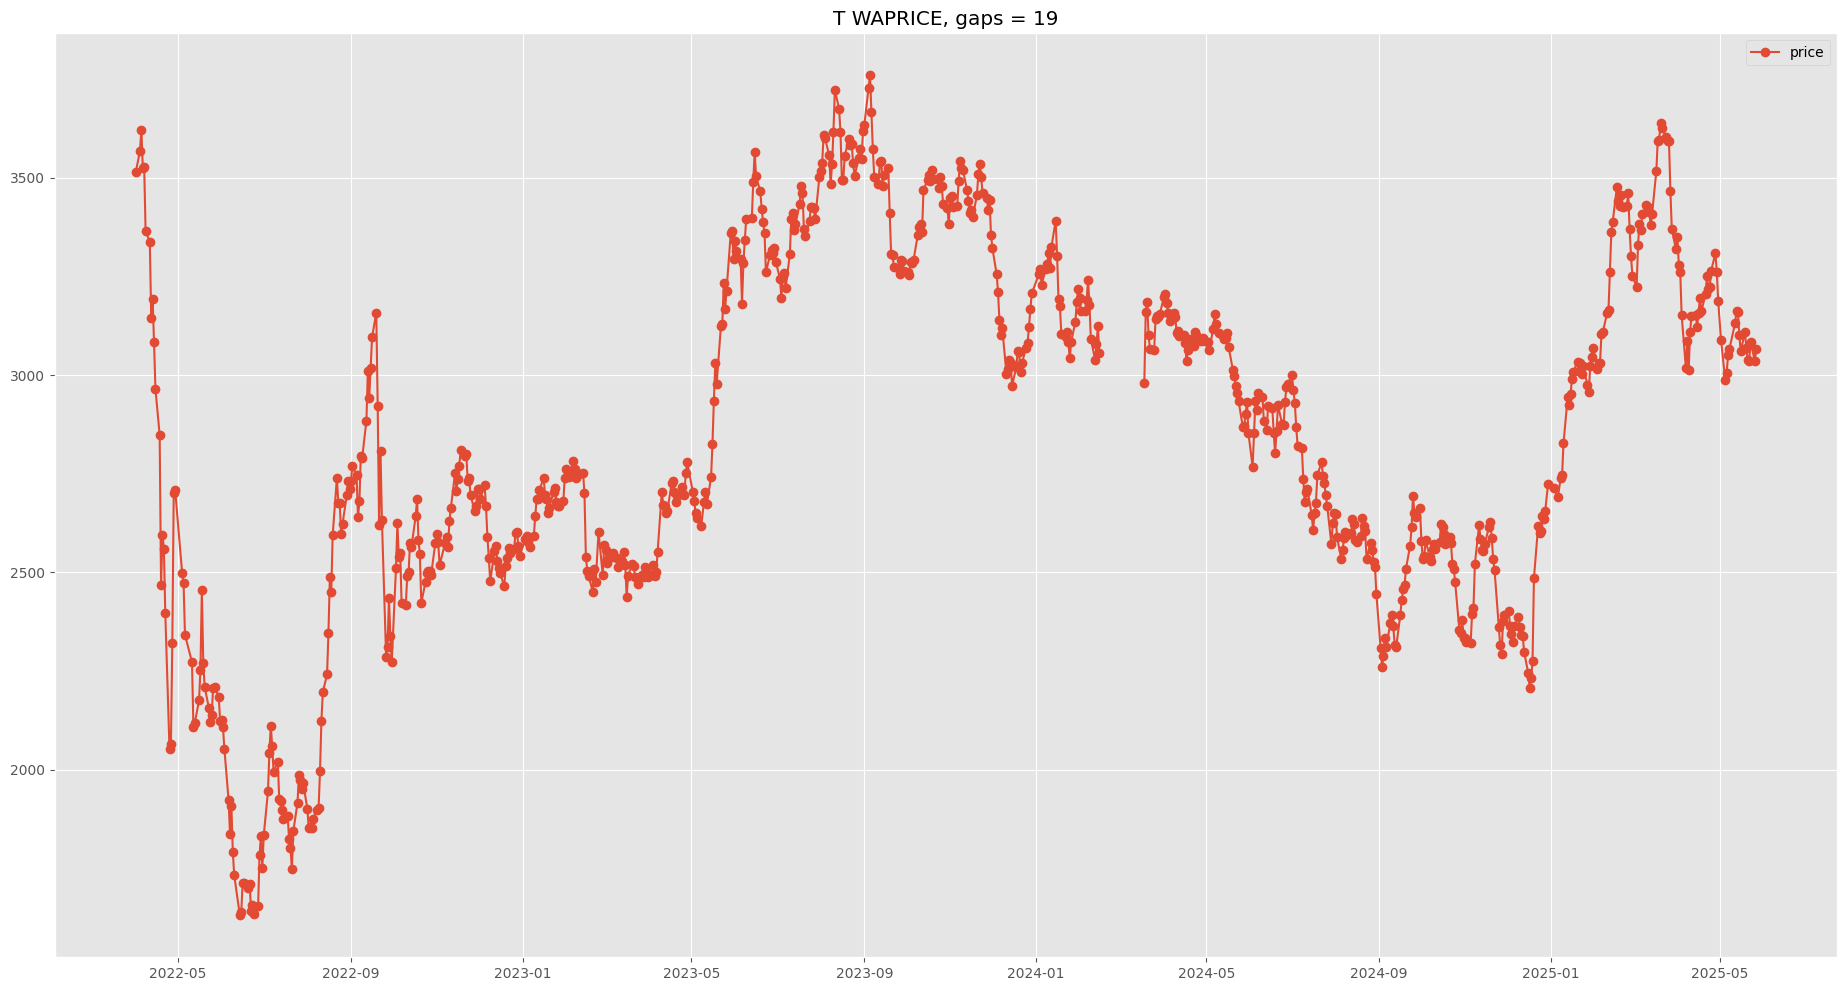

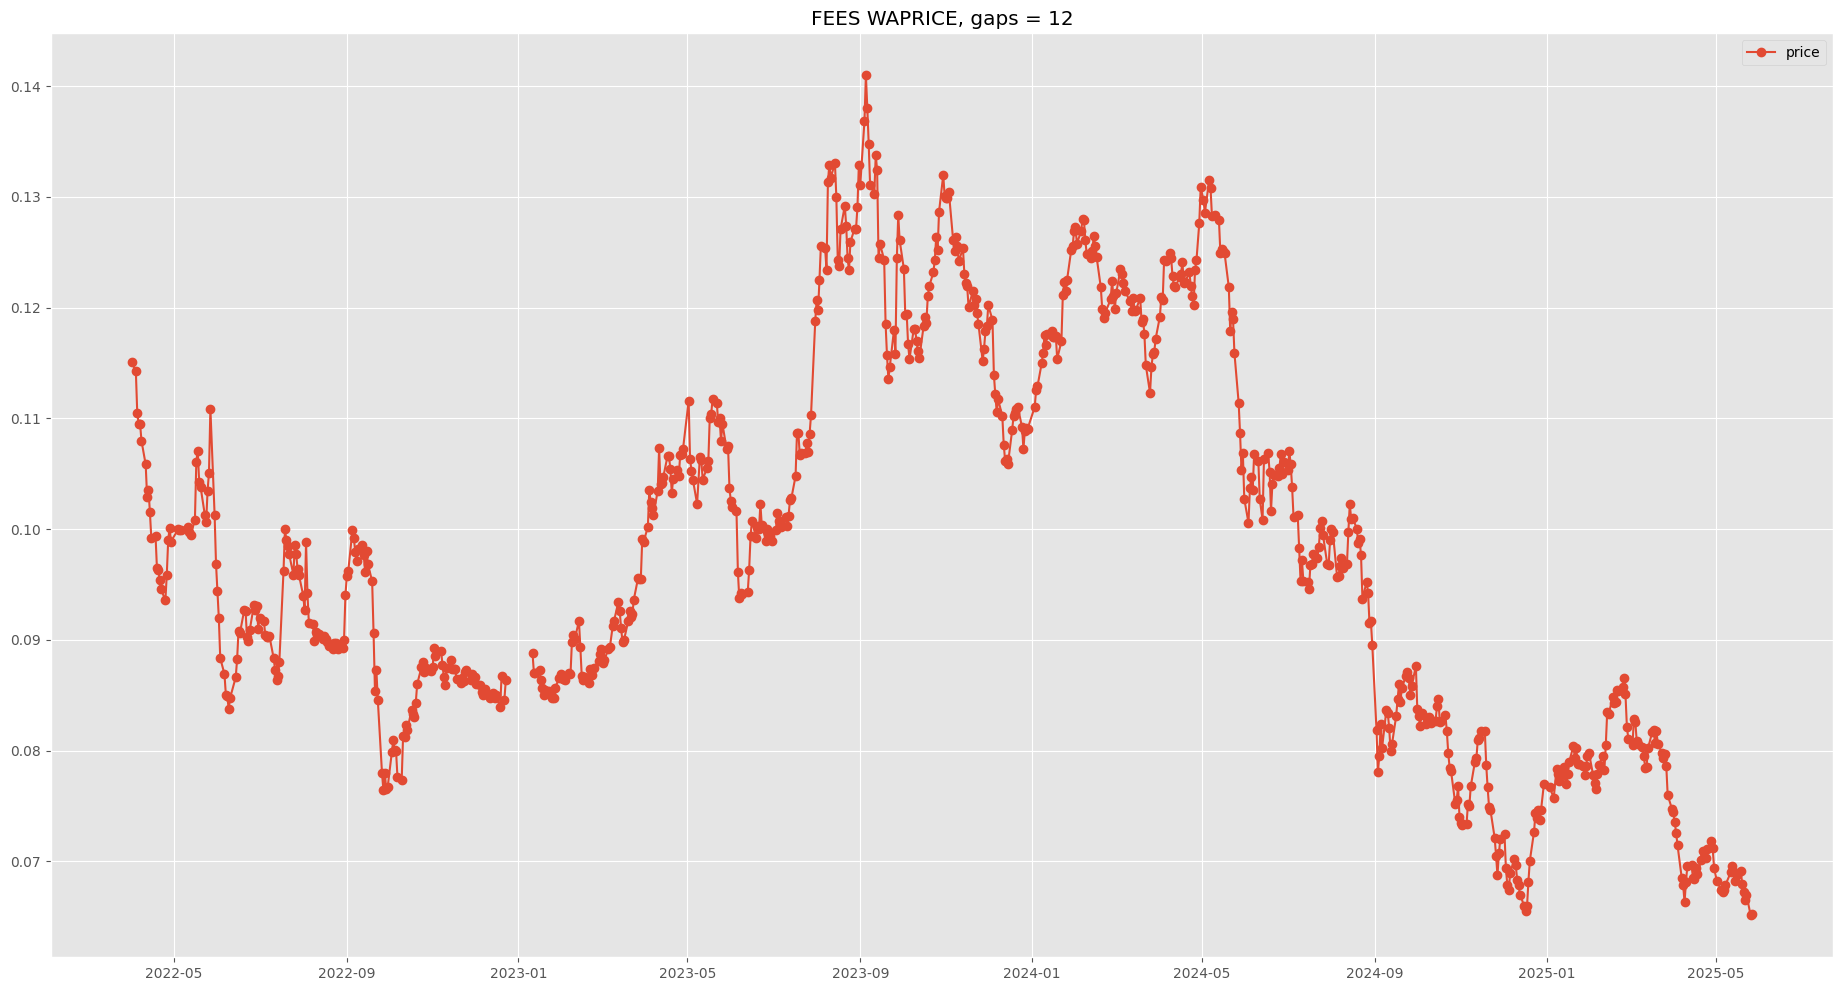

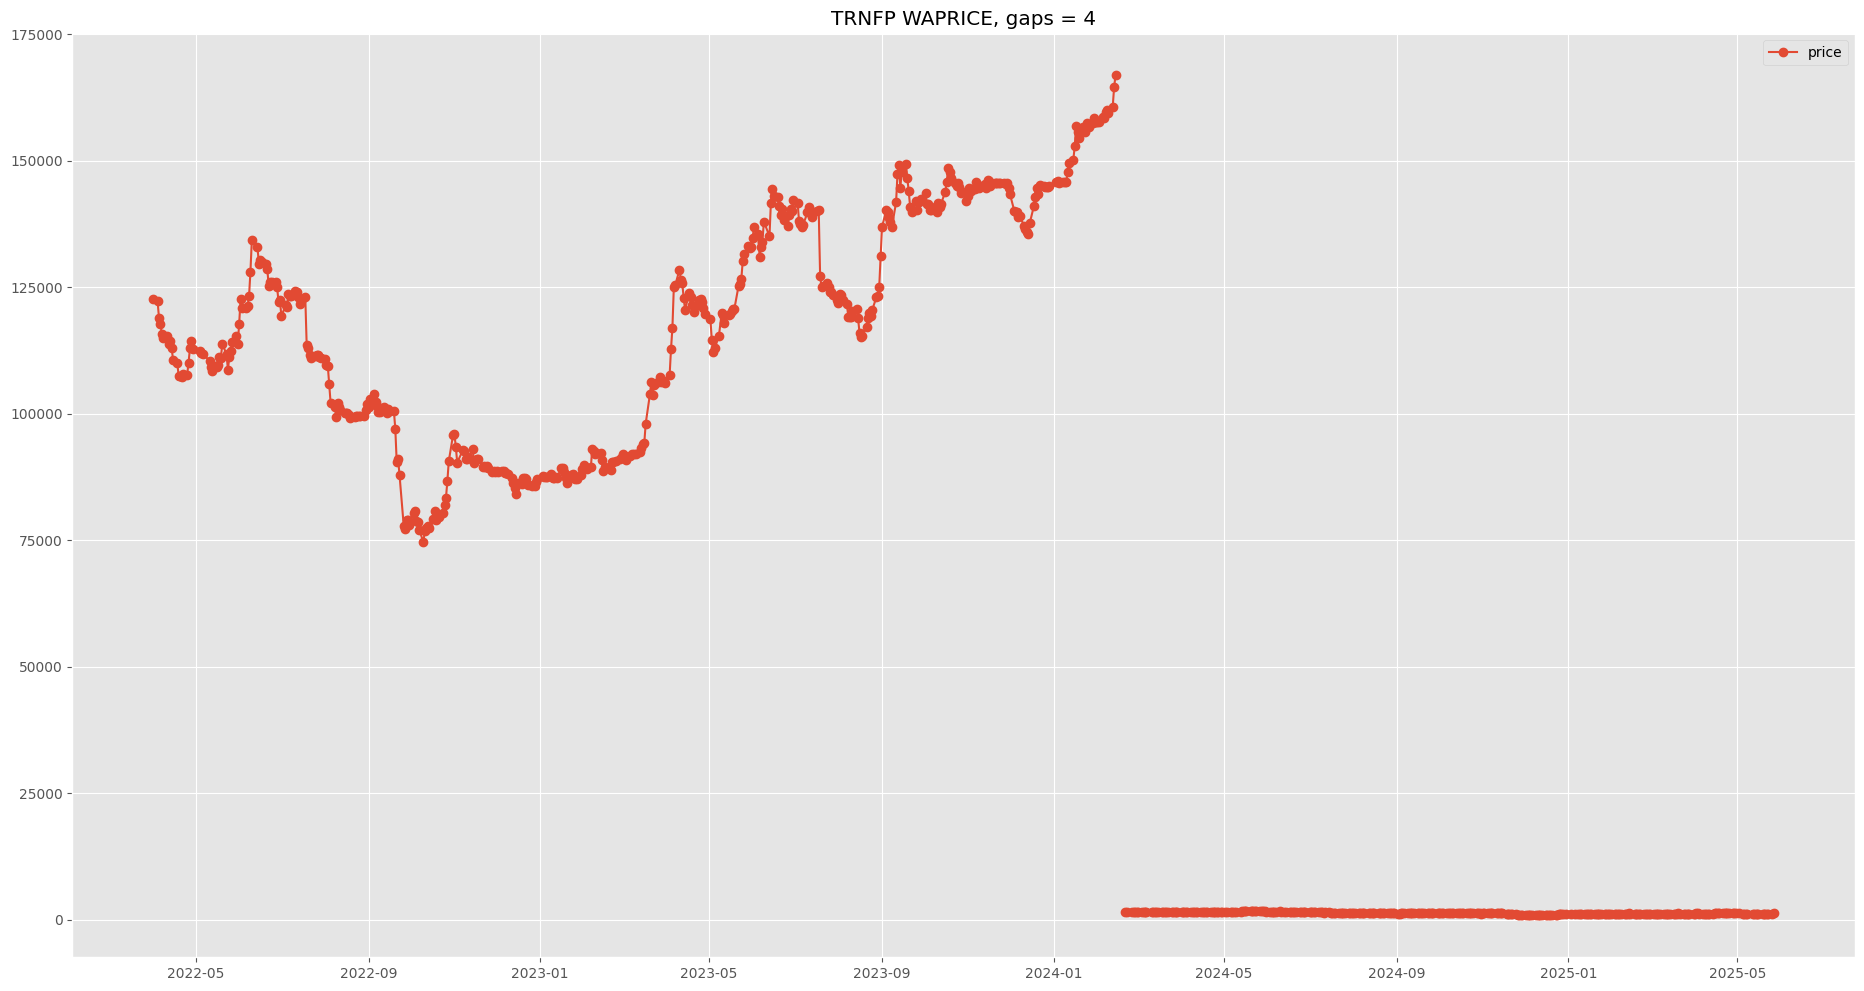

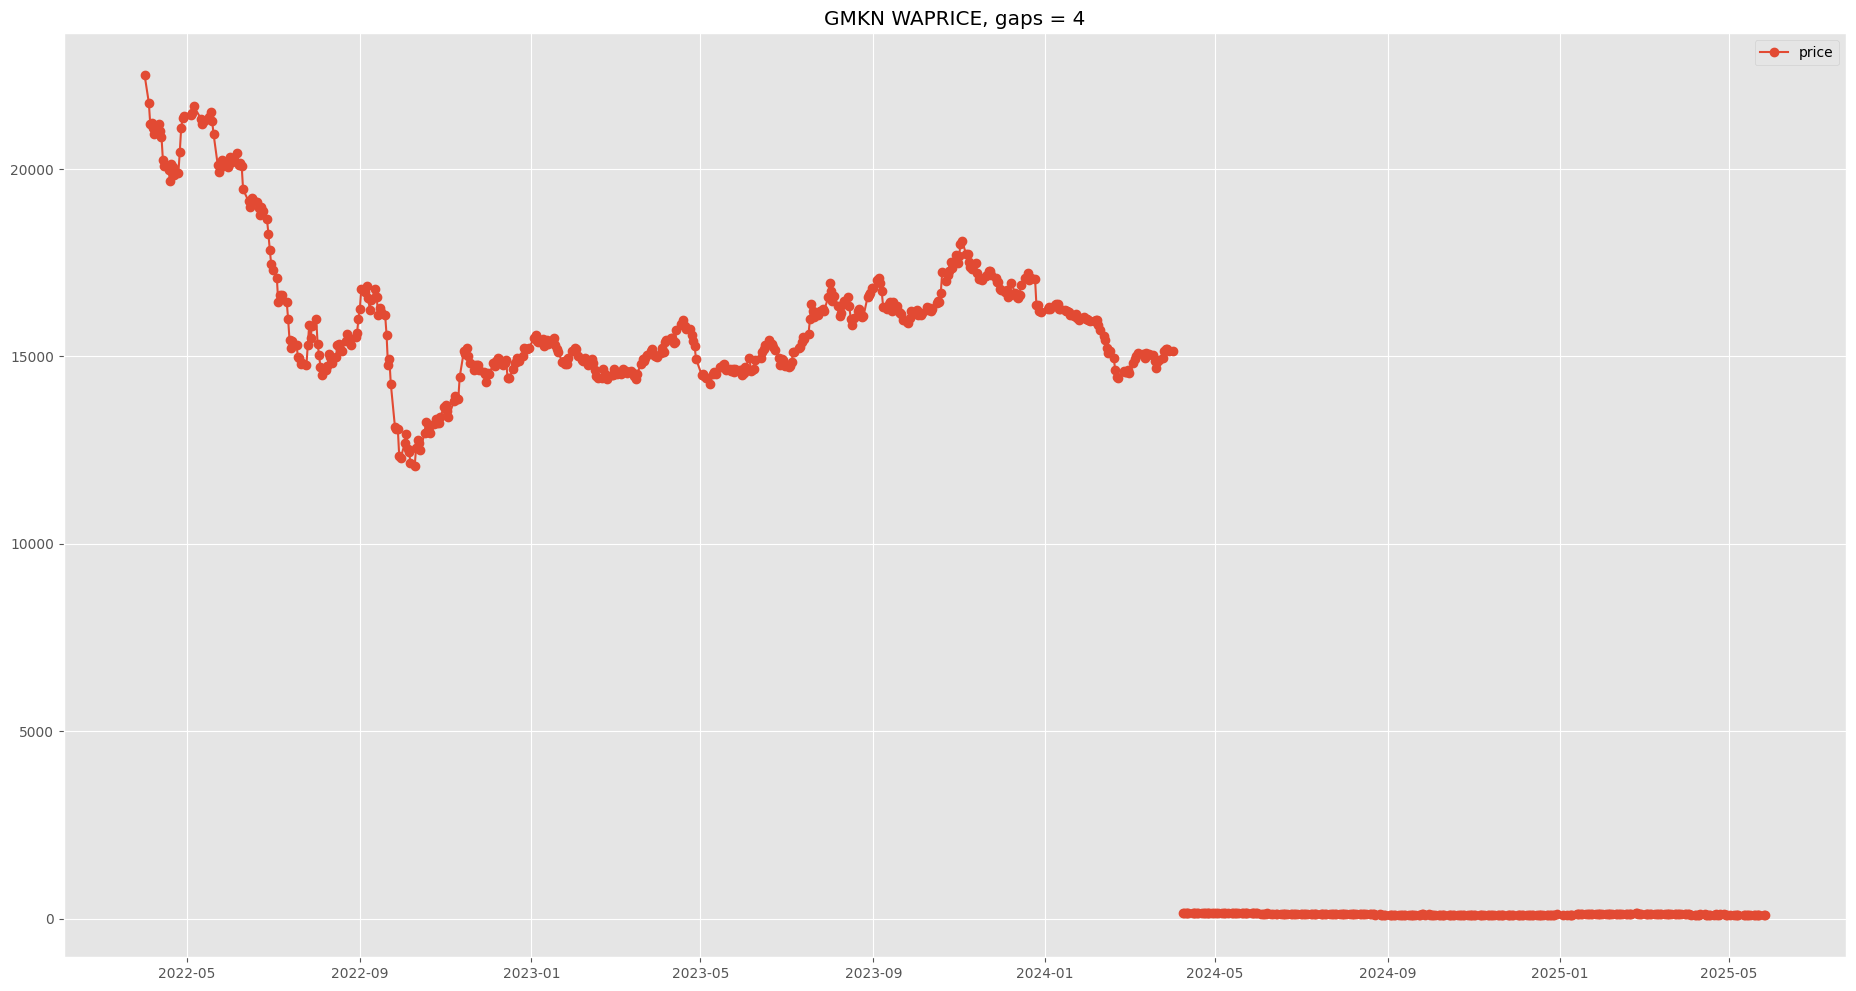

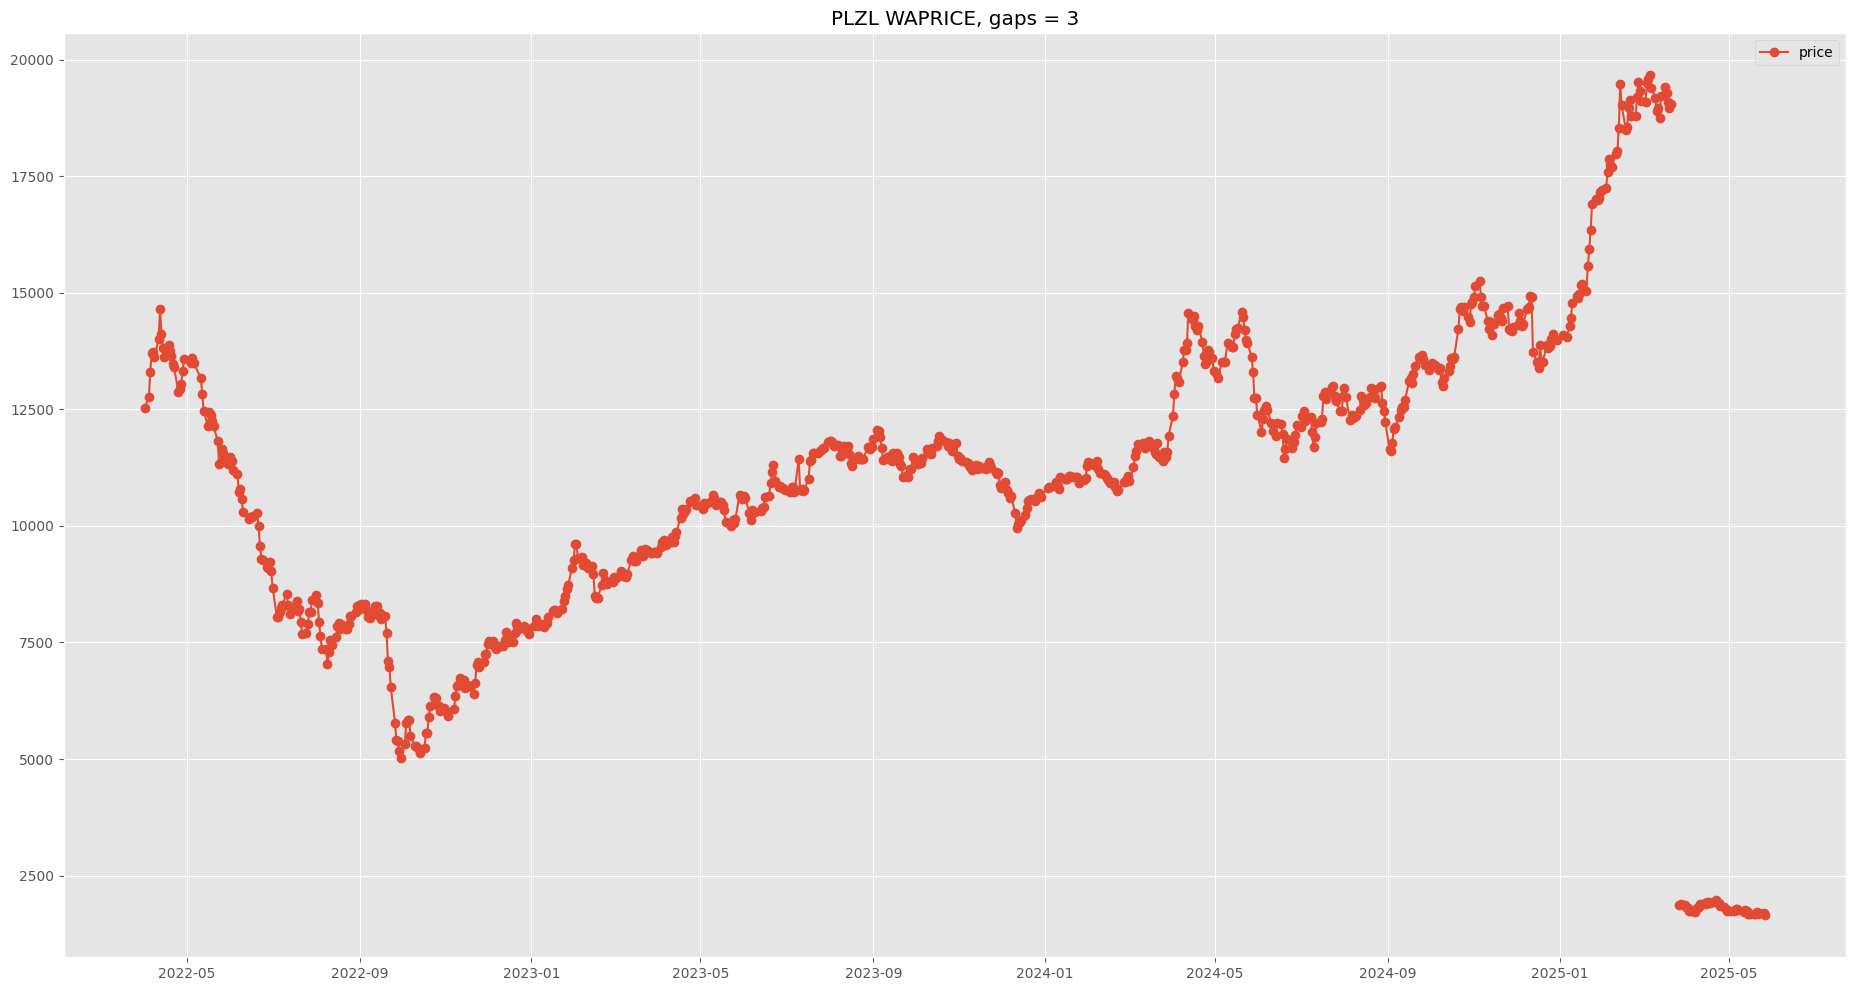

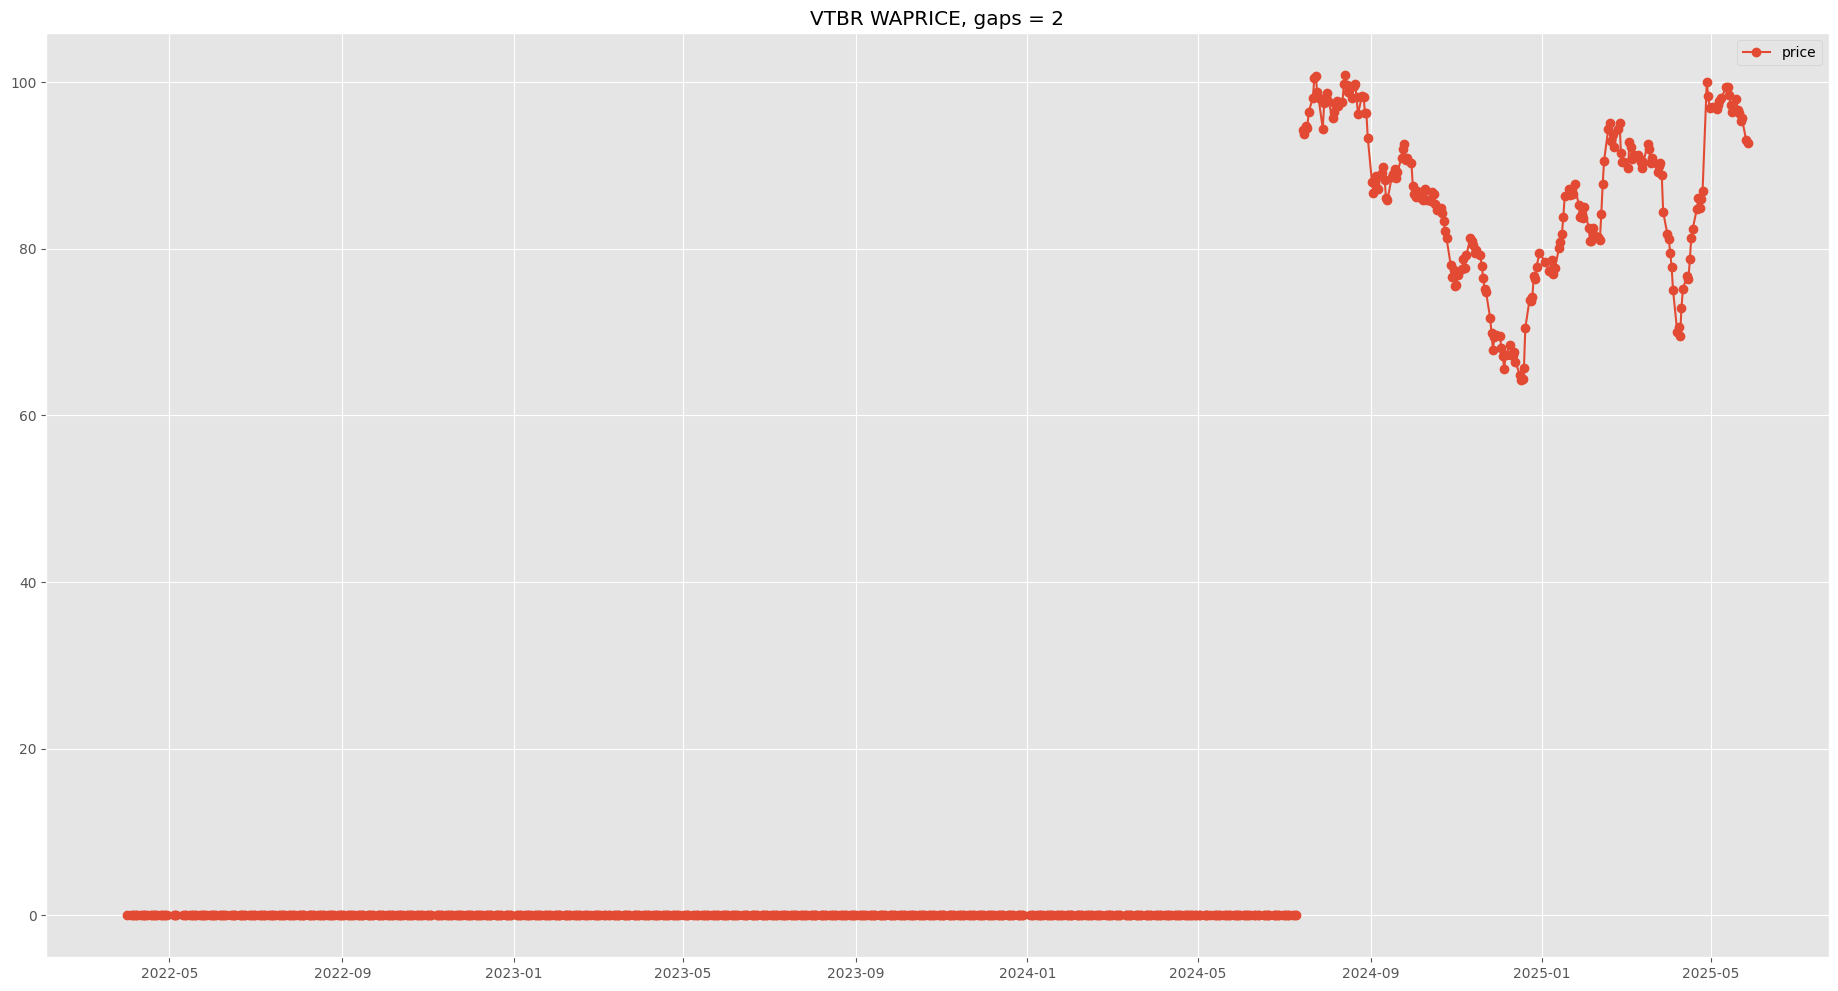

In [124]:
for ticker in list_of_tickers_with_gaps.index[list_of_tickers_with_gaps.values > 0]:
    plt.figure(figsize=(23, 12))

    plt.title(f'{ticker} WAPRICE, gaps = {list_of_tickers_with_gaps[ticker]}')

    plt.plot(df[df['SECID'] == ticker]['WAPRICE'], 
             marker='o',
             label='price')

    plt.legend()

Заполним пропуски через интерполияцию для следующих тикеров:

- YDEX
- VKCO
- FEES

У этих тикеров были сплиты или объединения акций, скорректируем историческую цену на нынешнее состояние а потом интерполируем пропуски там, где они были:

- TRNFP - сплит 100:1
- GMKN - сплит 100:1
- PLZL - сплит 10:1
- VTBR - обратный сплит 0,0002:1


##### Корректируем показатели после сплитов

In [125]:
tickers_to_correct = {}
for ticker in df.SECID.unique():
    if ticker in (results_splits['secid'].values):
        splits_row = results_splits[results_splits['secid'] == ticker]
        tickers_to_correct[ticker] = (splits_row['after'].values[-1] / splits_row['before'].values[-1],
                                      pd.to_datetime(splits_row['tradedate'].values[-1], format='%Y-%m-%d'))

tickers_to_correct

{'GMKN': (100.0, Timestamp('2024-04-08 00:00:00')),
 'PLZL': (10.0, Timestamp('2025-03-27 00:00:00')),
 'TRNFP': (100.0, Timestamp('2024-02-21 00:00:00')),
 'VTBR': (0.0002, Timestamp('2024-07-15 00:00:00'))}

In [126]:
df_copy = df.copy()

In [127]:
for t in tickers_to_correct.items():
    print(t)

('GMKN', (100.0, Timestamp('2024-04-08 00:00:00')))
('PLZL', (10.0, Timestamp('2025-03-27 00:00:00')))
('TRNFP', (100.0, Timestamp('2024-02-21 00:00:00')))
('VTBR', (0.0002, Timestamp('2024-07-15 00:00:00')))


In [128]:
for ticker, item in tickers_to_correct.items():
    value = item[0]
    split_date = item[1]

    df_ticker_before_split = df_copy[(df_copy['SECID'] == ticker) & (df_copy.index < split_date)]
    # df_ticker_after_split = df_copy[(df_copy['SECID'] == ticker) & (df_copy.index >= split_date)]

    df_ticker_before_split = pd.concat([
        df_ticker_before_split.loc[:, 'SECID'],
        df_ticker_before_split.loc[:, ['WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME']] / value,
        ], axis=1)

    df[(df['SECID'] == ticker) & (df.index < split_date)] = df_ticker_before_split
    

##### Скорректированные тикеры

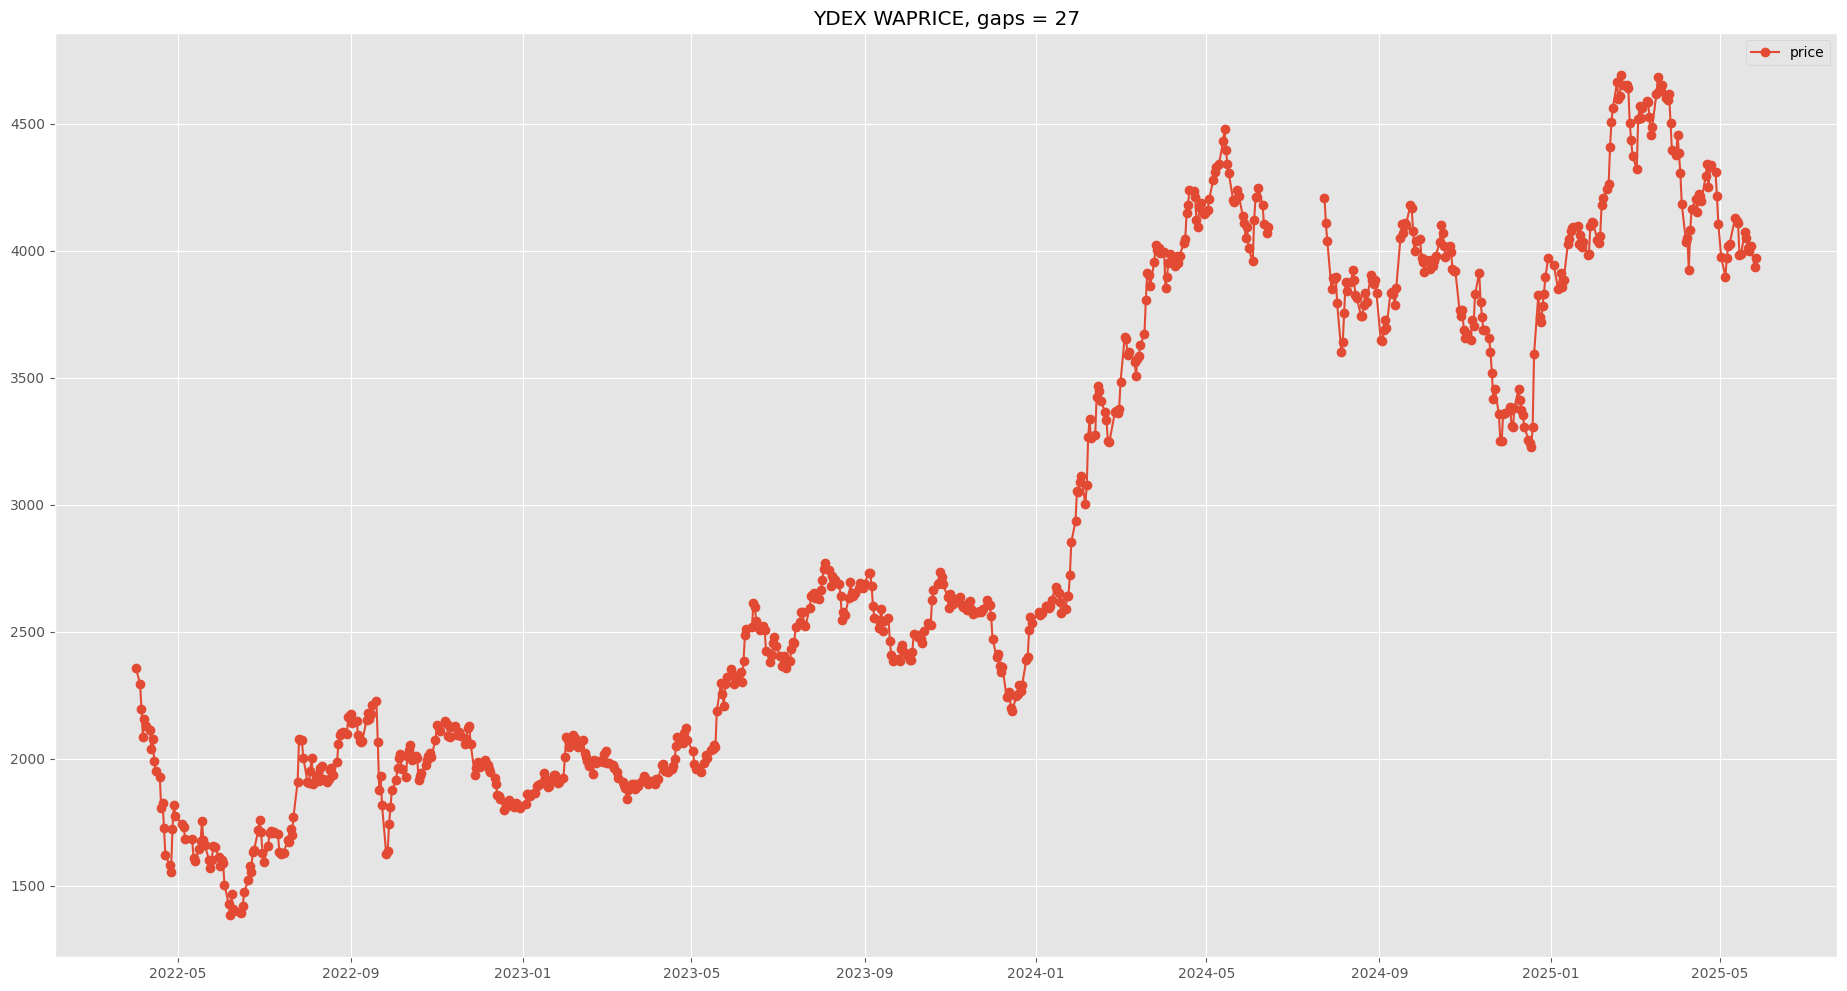

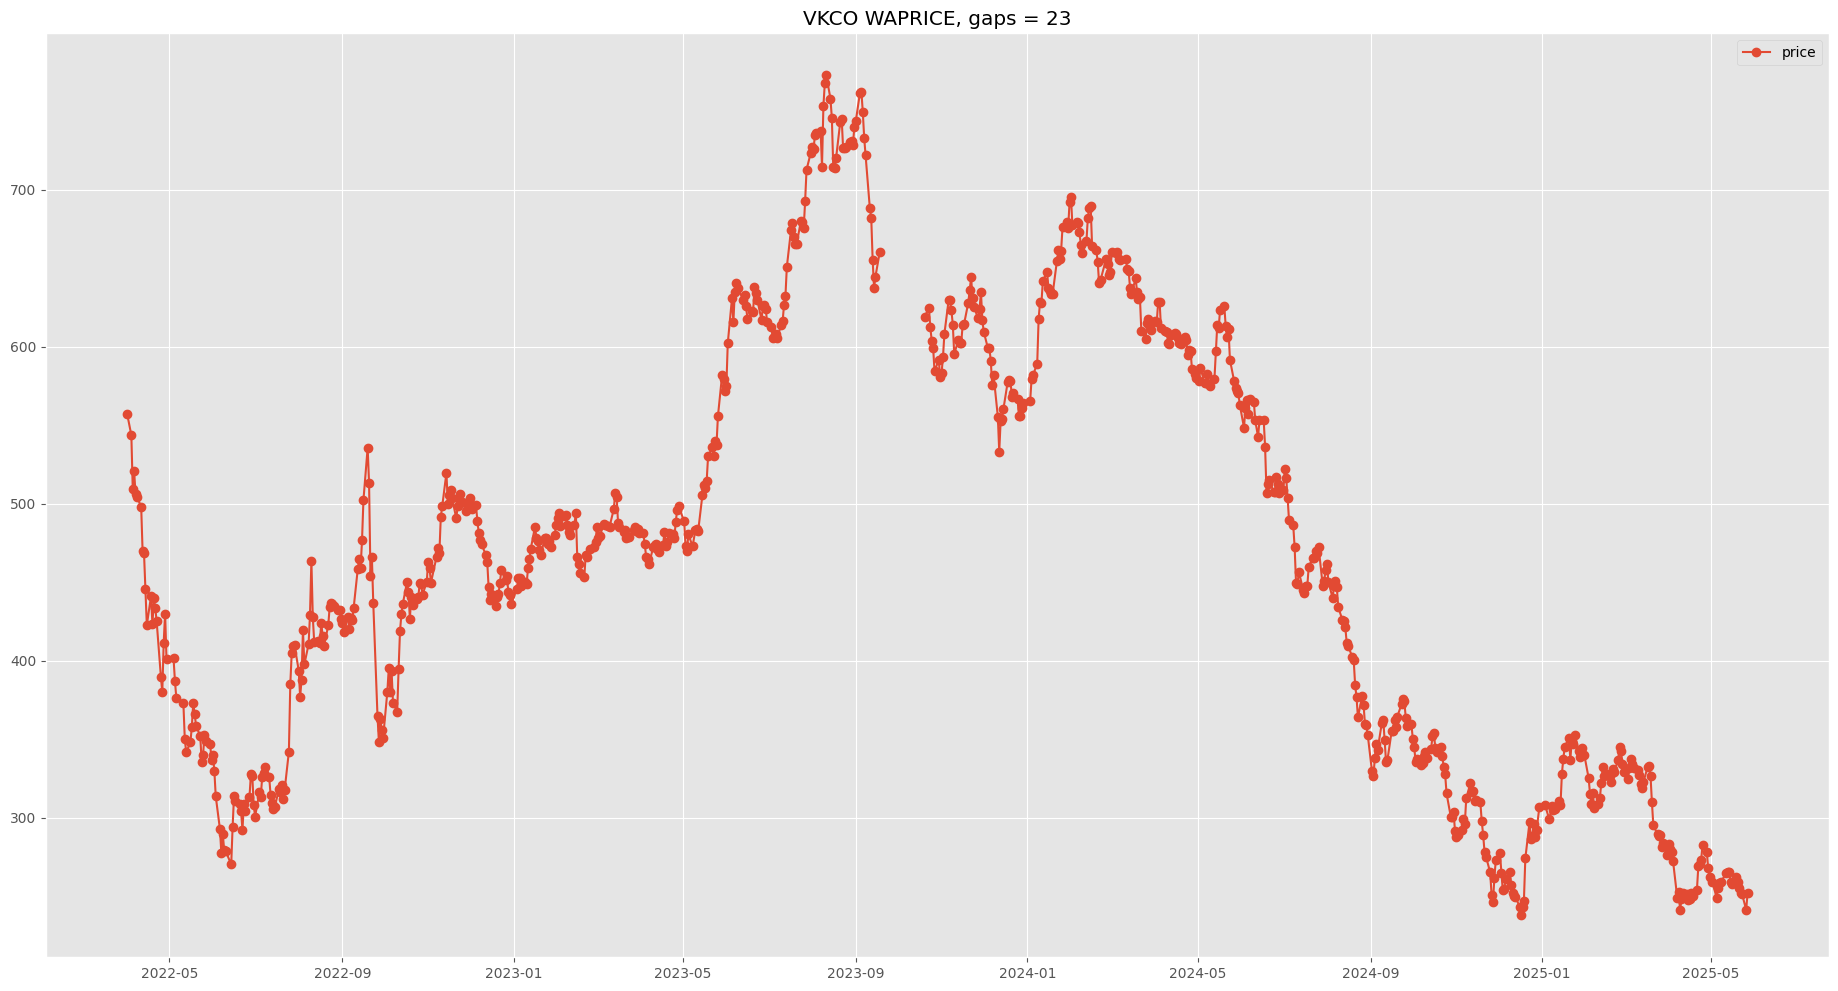

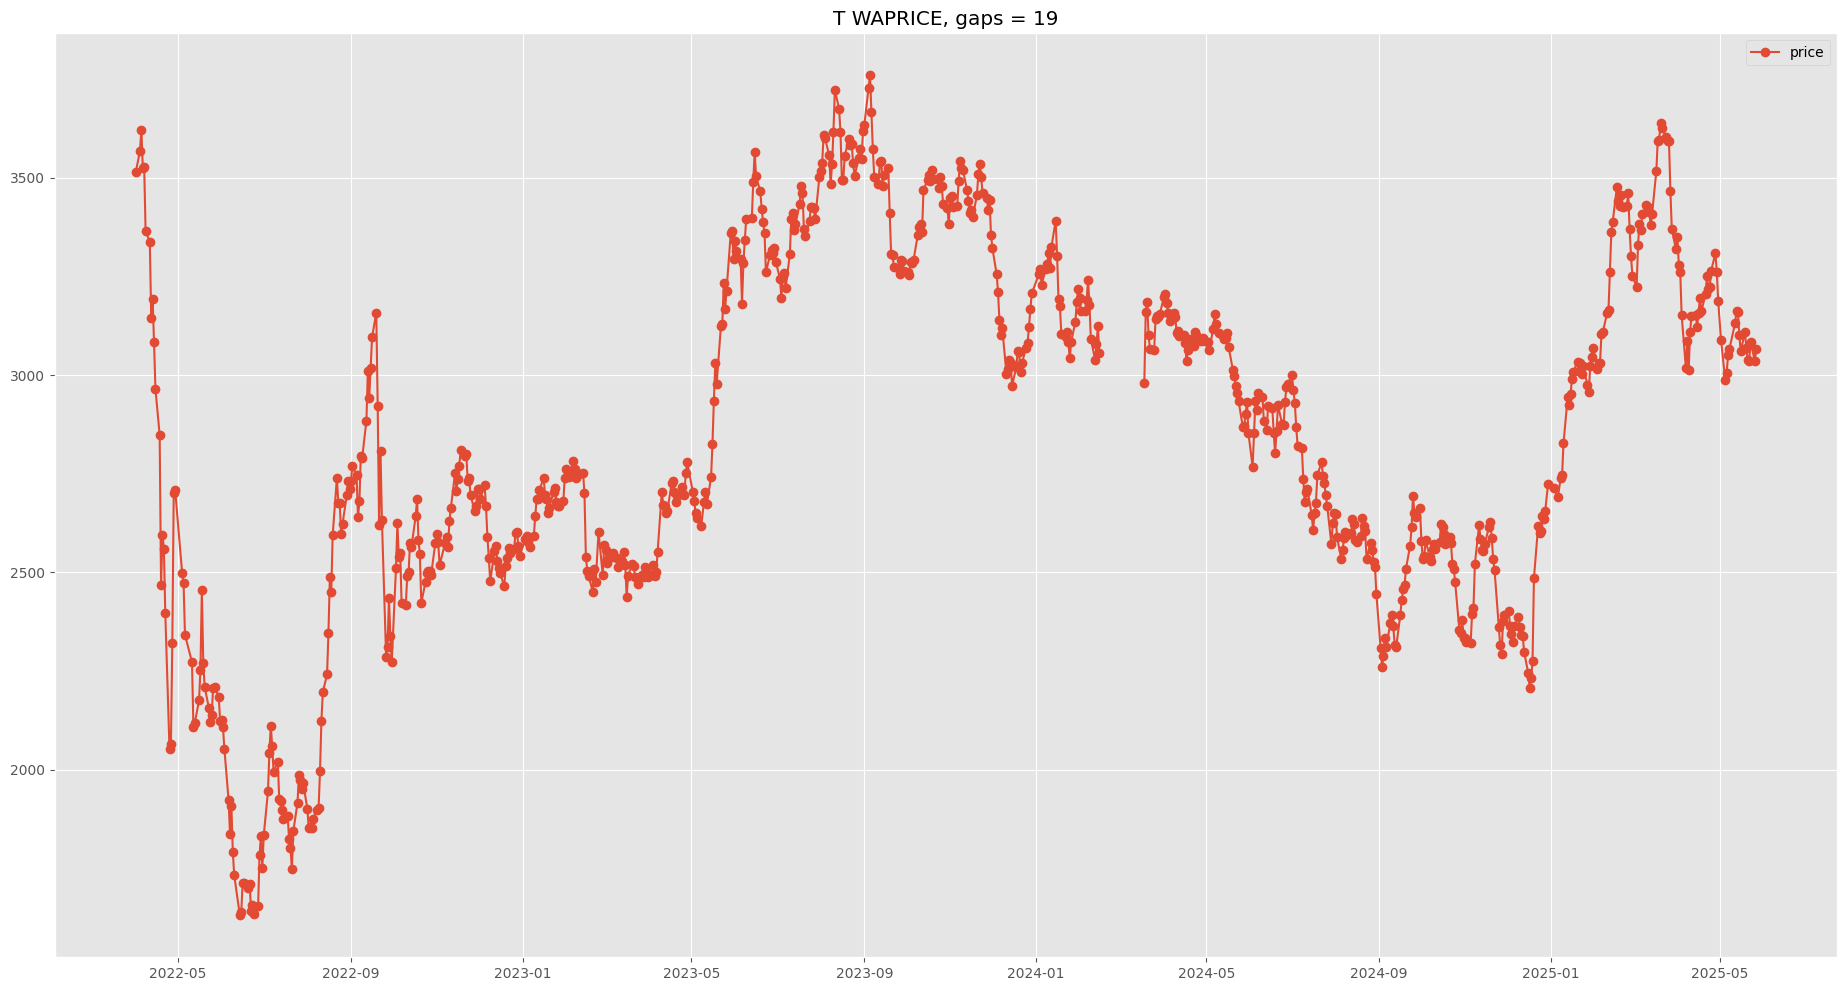

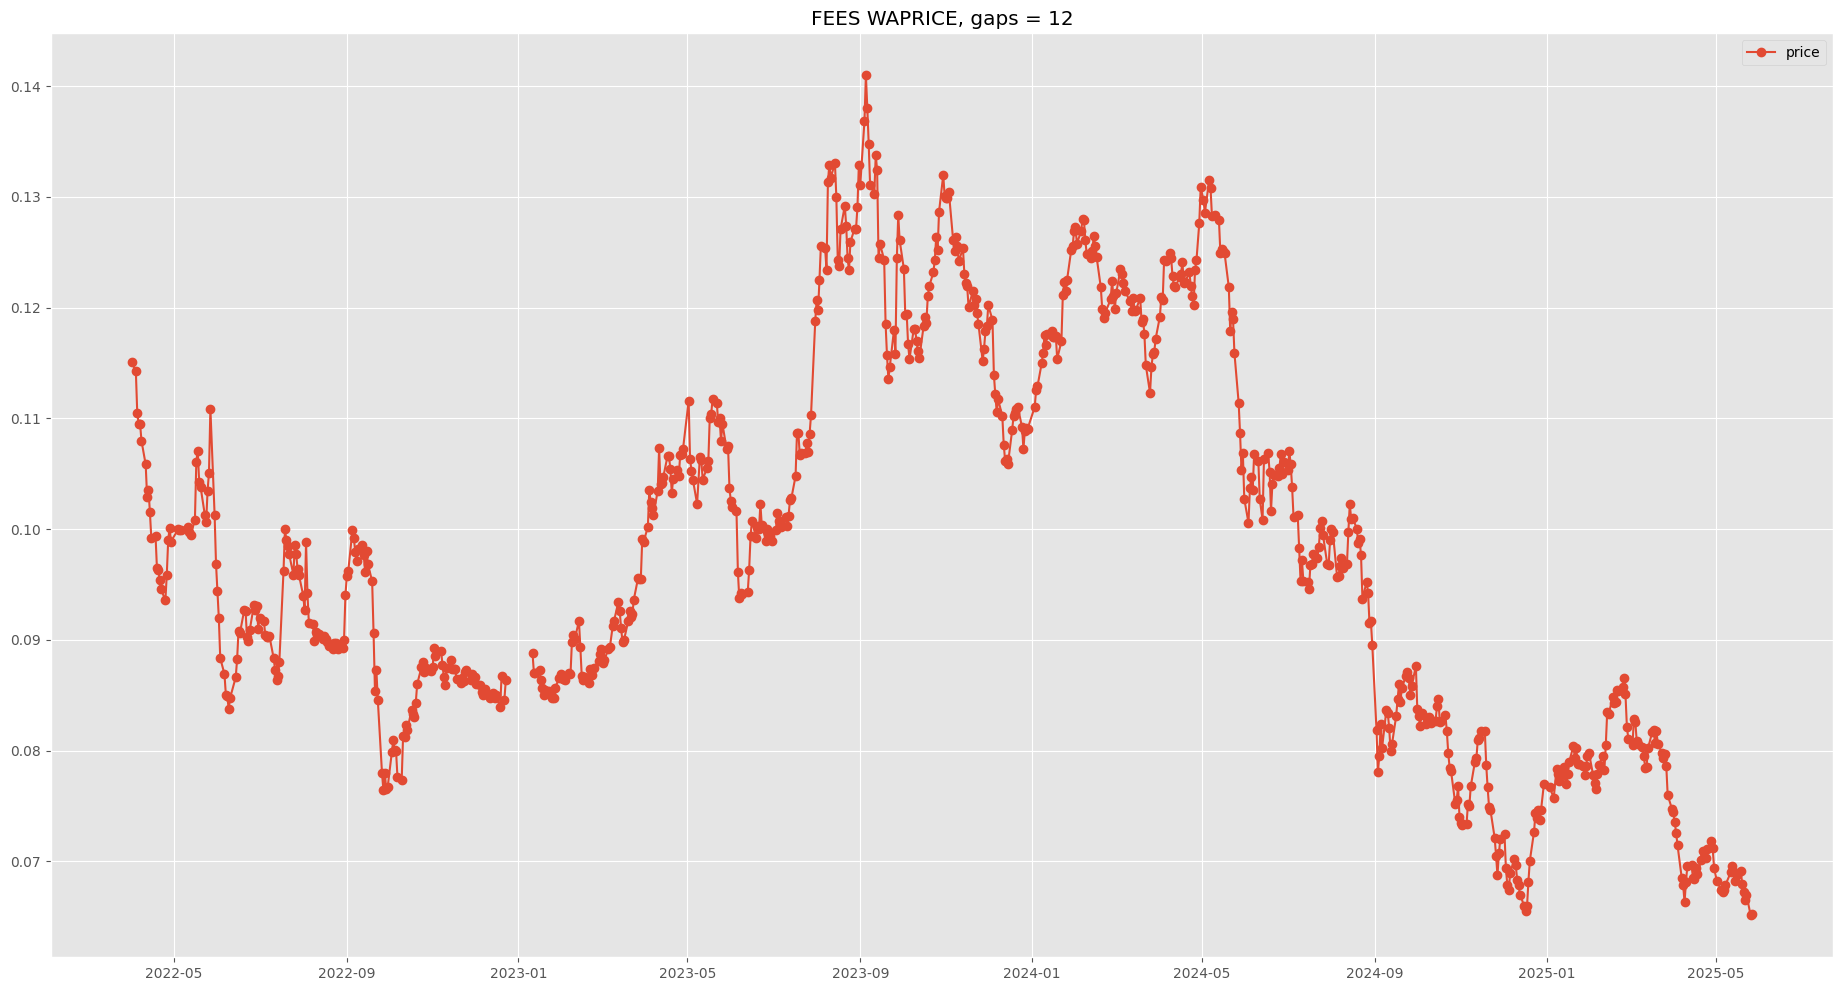

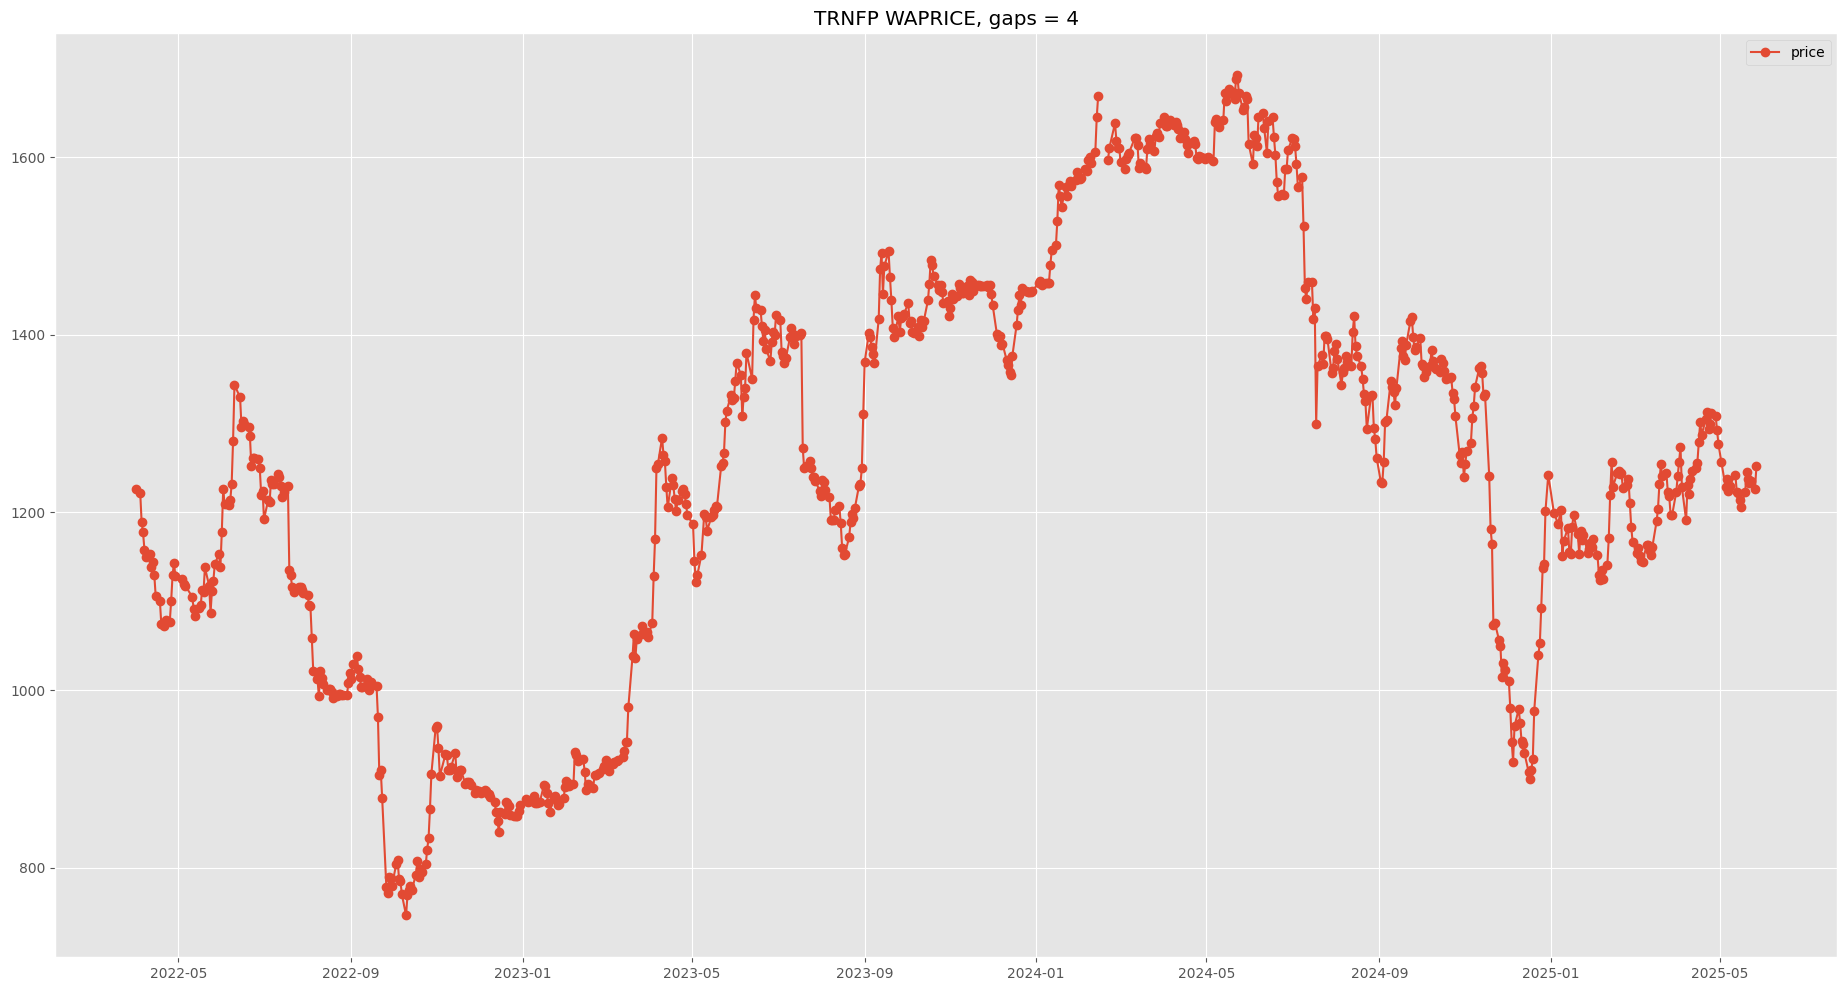

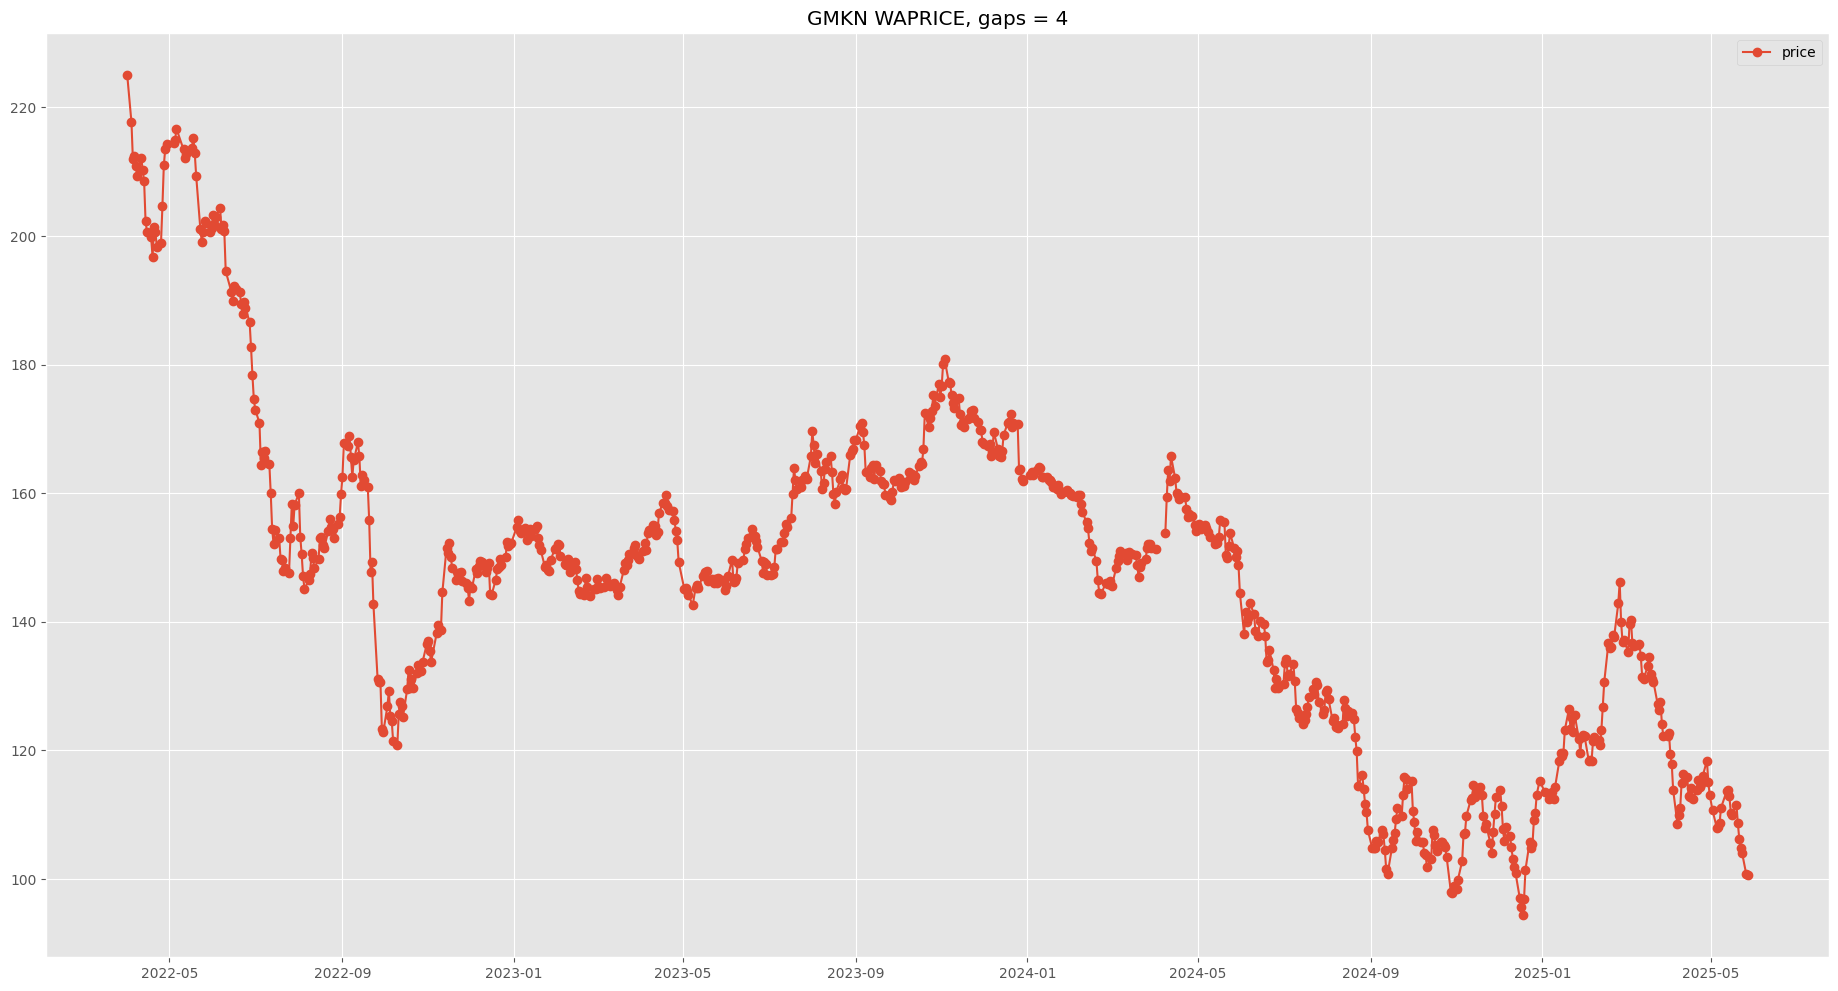

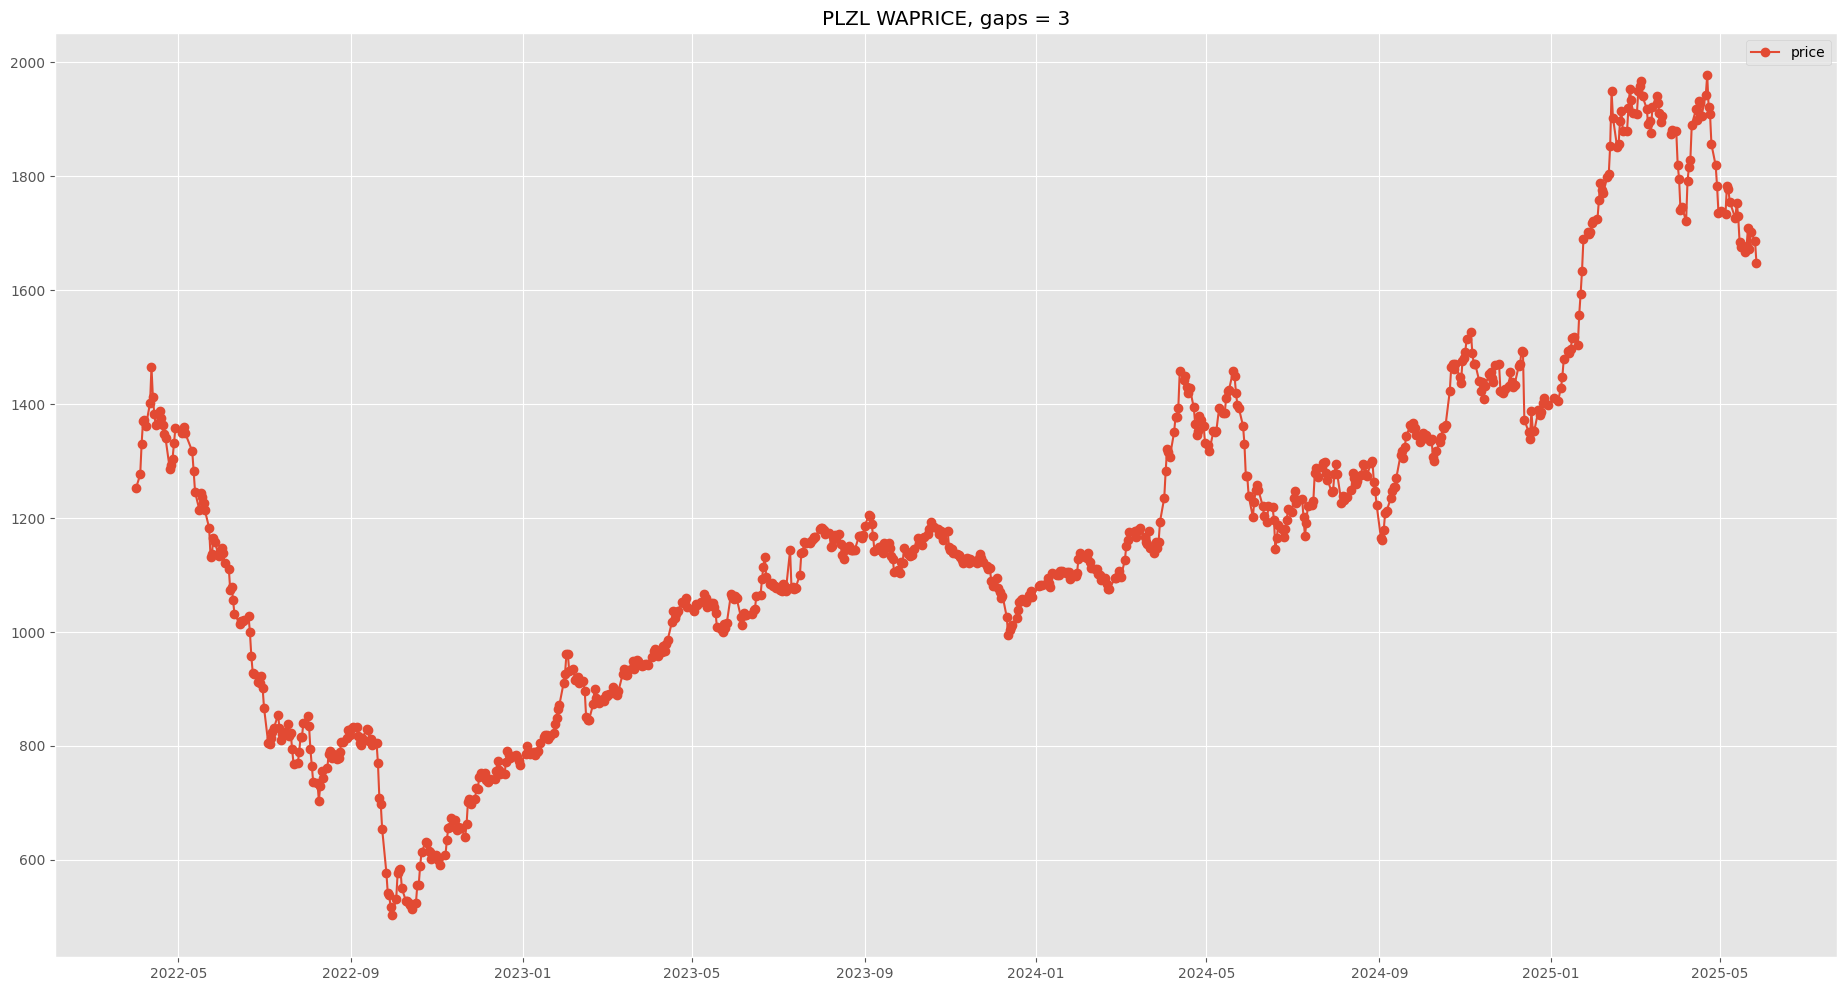

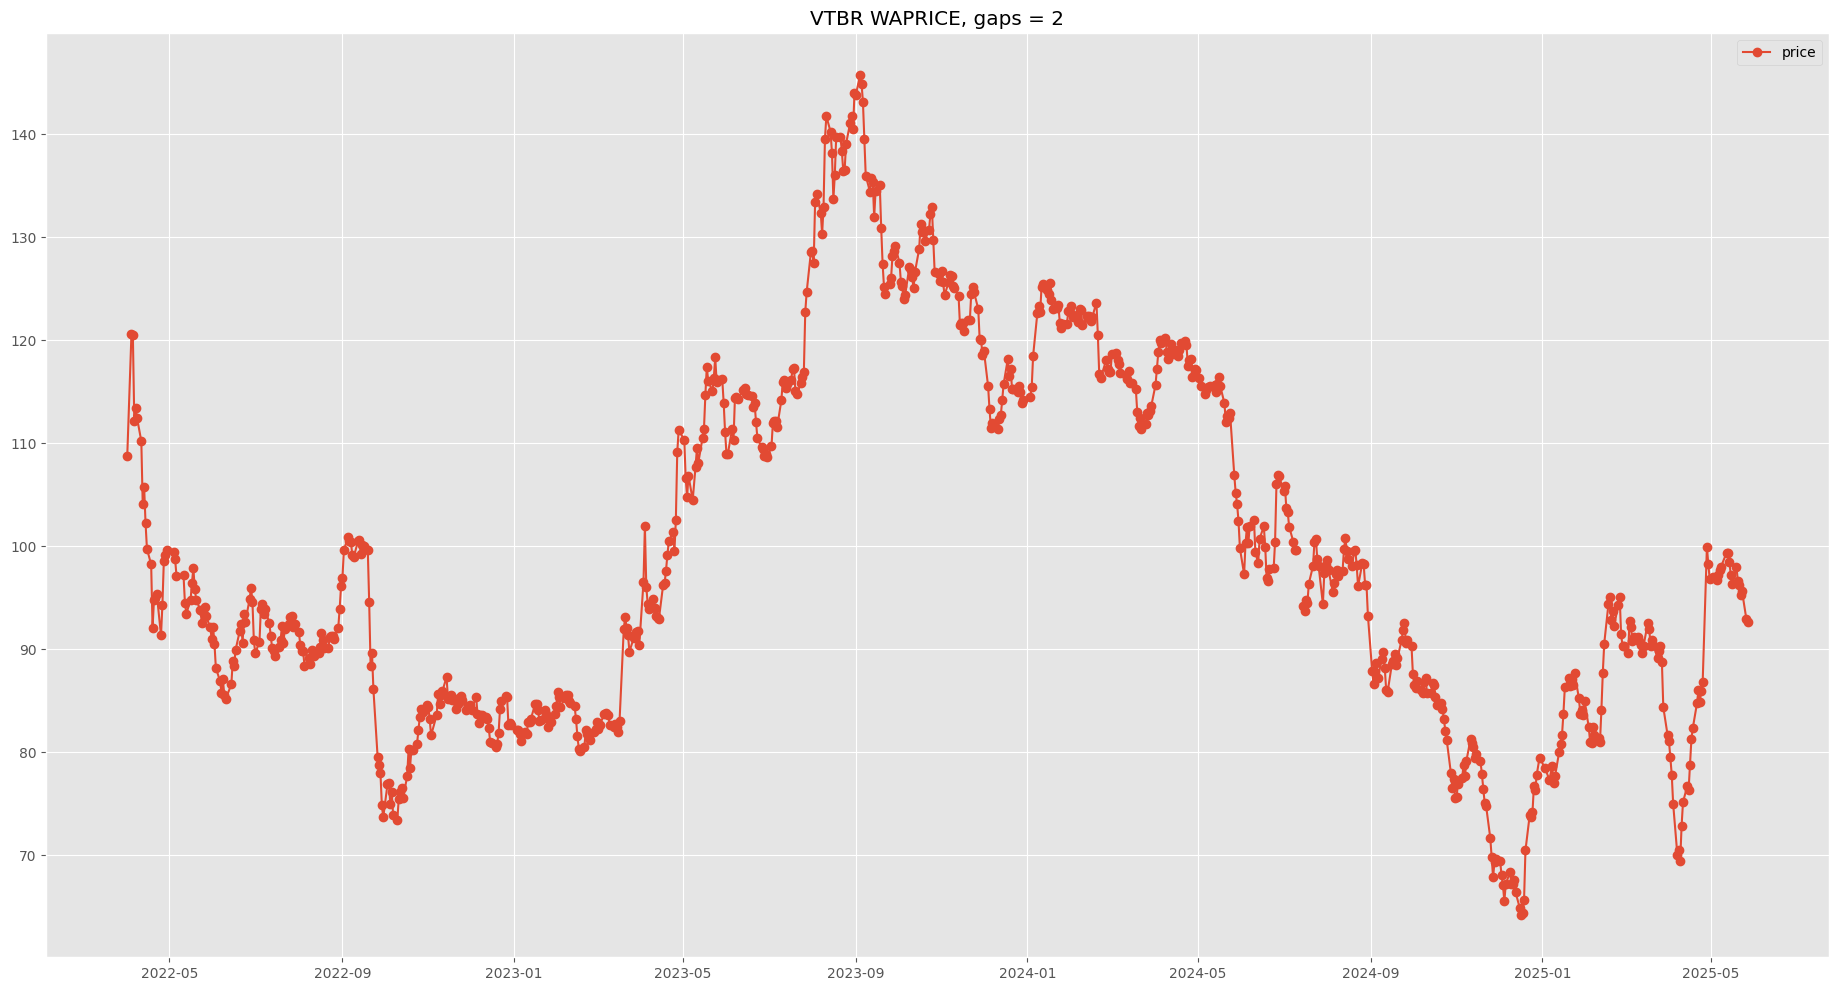

In [129]:
for ticker in list_of_tickers_with_gaps.index[list_of_tickers_with_gaps.values > 0]:
    plt.figure(figsize=(23, 12))

    plt.title(f'{ticker} WAPRICE, gaps = {list_of_tickers_with_gaps[ticker]}')

    plt.plot(df[df['SECID'] == ticker]['WAPRICE'], 
             marker='o',
             label='price')

    plt.legend()

##### Дозаполняем пропуски

In [130]:
list_of_tickers_with_gaps = df.groupby('SECID')['CLOSE'].apply(lambda x: x.isna().sum()).sort_values(ascending=False) 
list_of_tickers_with_gaps

SECID
YDEX     27
VKCO     23
T        19
FEES     14
VTBR      4
TRNFP     4
GMKN      4
PLZL      3
SBERP     0
POSI      0
ROSN      0
RTKM      0
RUAL      0
SBER      0
SNGSP     0
SELG      0
SMLT      0
SNGS      0
PHOR      0
TATN      0
TATNP     0
UPRO      0
PIKK      0
AFKS      0
AFLT      0
NLMK      0
ALRS      0
BSPB      0
CBOM      0
CHMF      0
ENPG      0
FLOT      0
GAZP      0
HYDR      0
IRAO      0
LKOH      0
MAGN      0
MGNT      0
MOEX      0
MSNG      0
MTLR      0
MTLRP     0
MTSS      0
NVTK      0
Name: CLOSE, dtype: int64

Заполняем через интерполяцию (квадратичную)

In [131]:
for ticker in list_of_tickers_with_gaps[list_of_tickers_with_gaps > 0].index:
    df_ticker = df[df['SECID'] == ticker]
    df_ticker = df_ticker.interpolate(method='polynomial', order=2)

    df[df['SECID'] == ticker] = df_ticker

##### Интерполированные пропуски

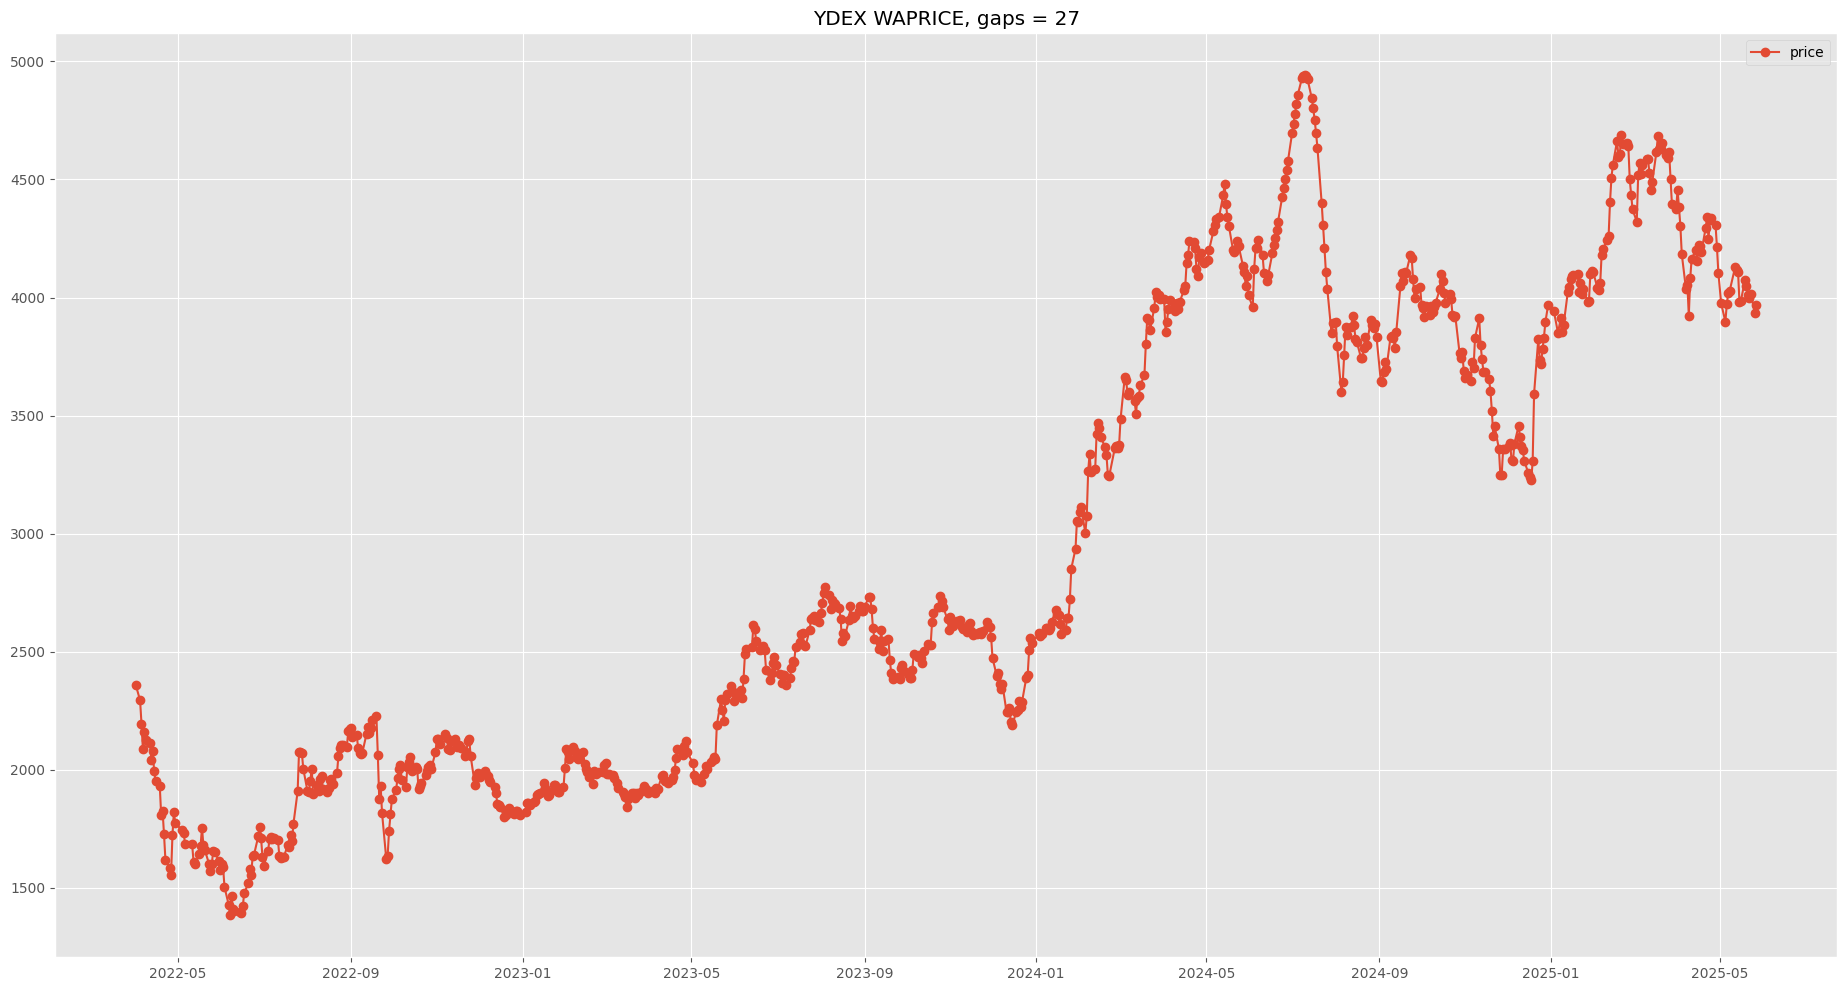

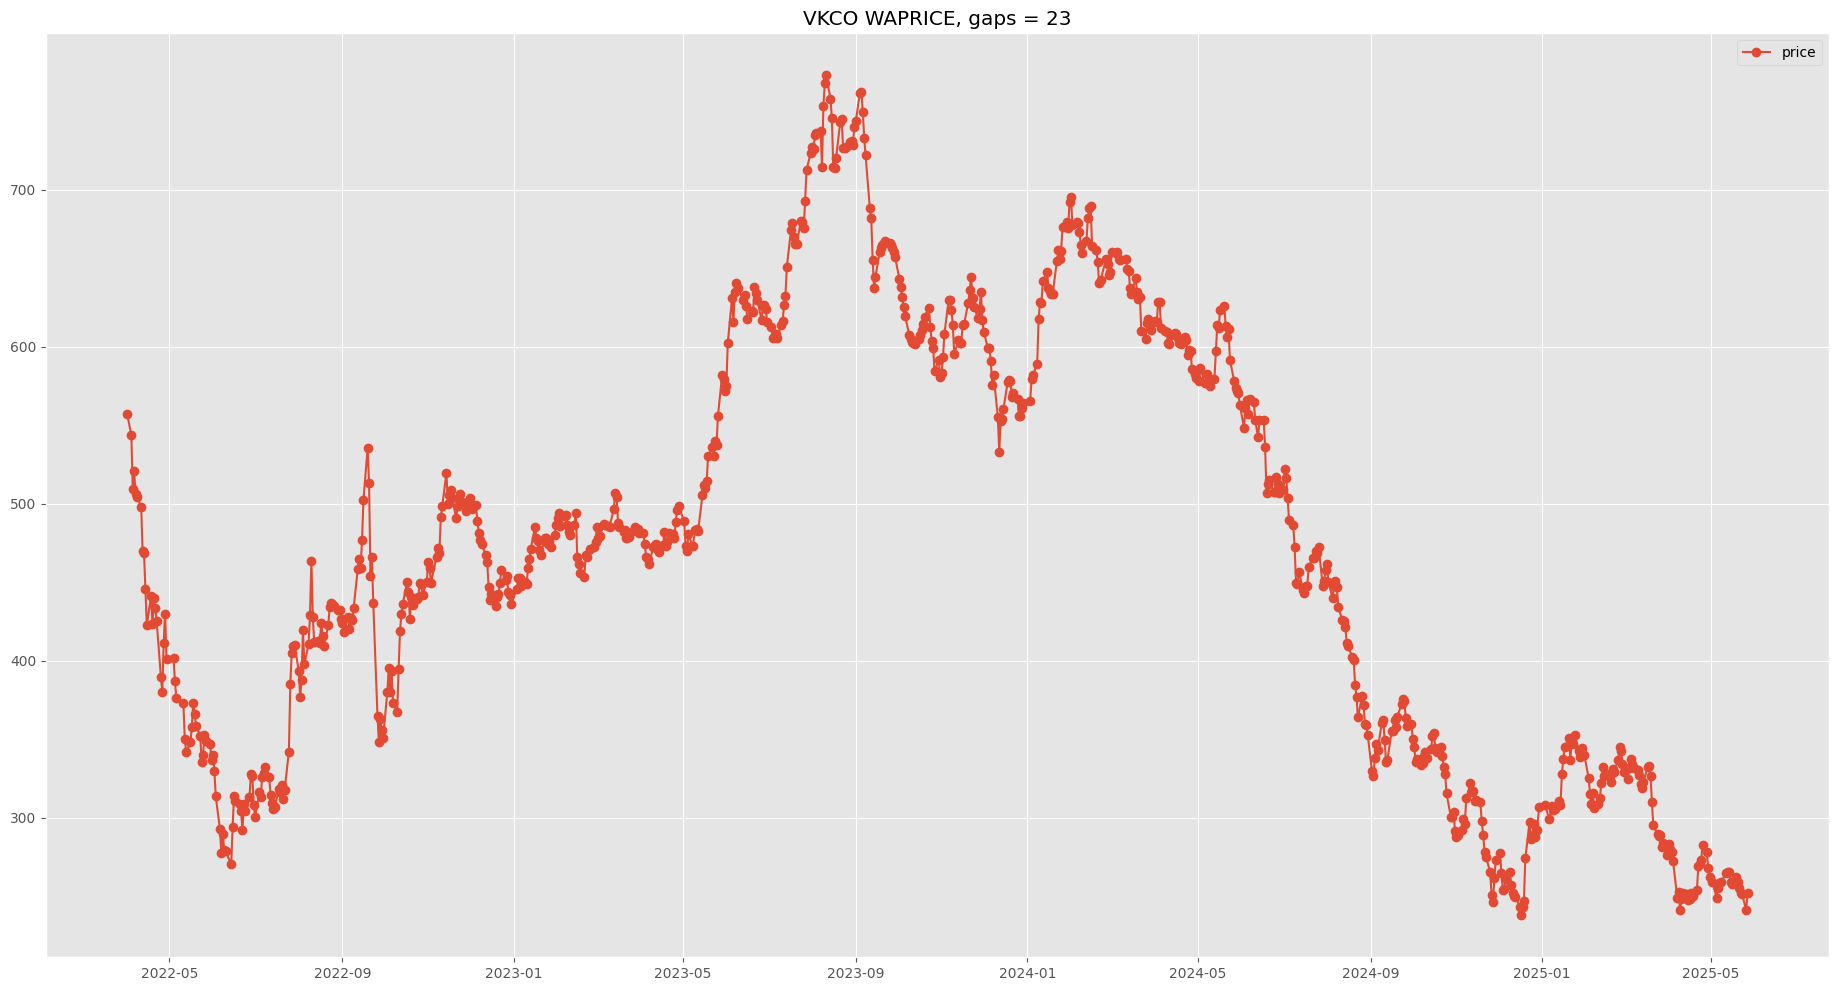

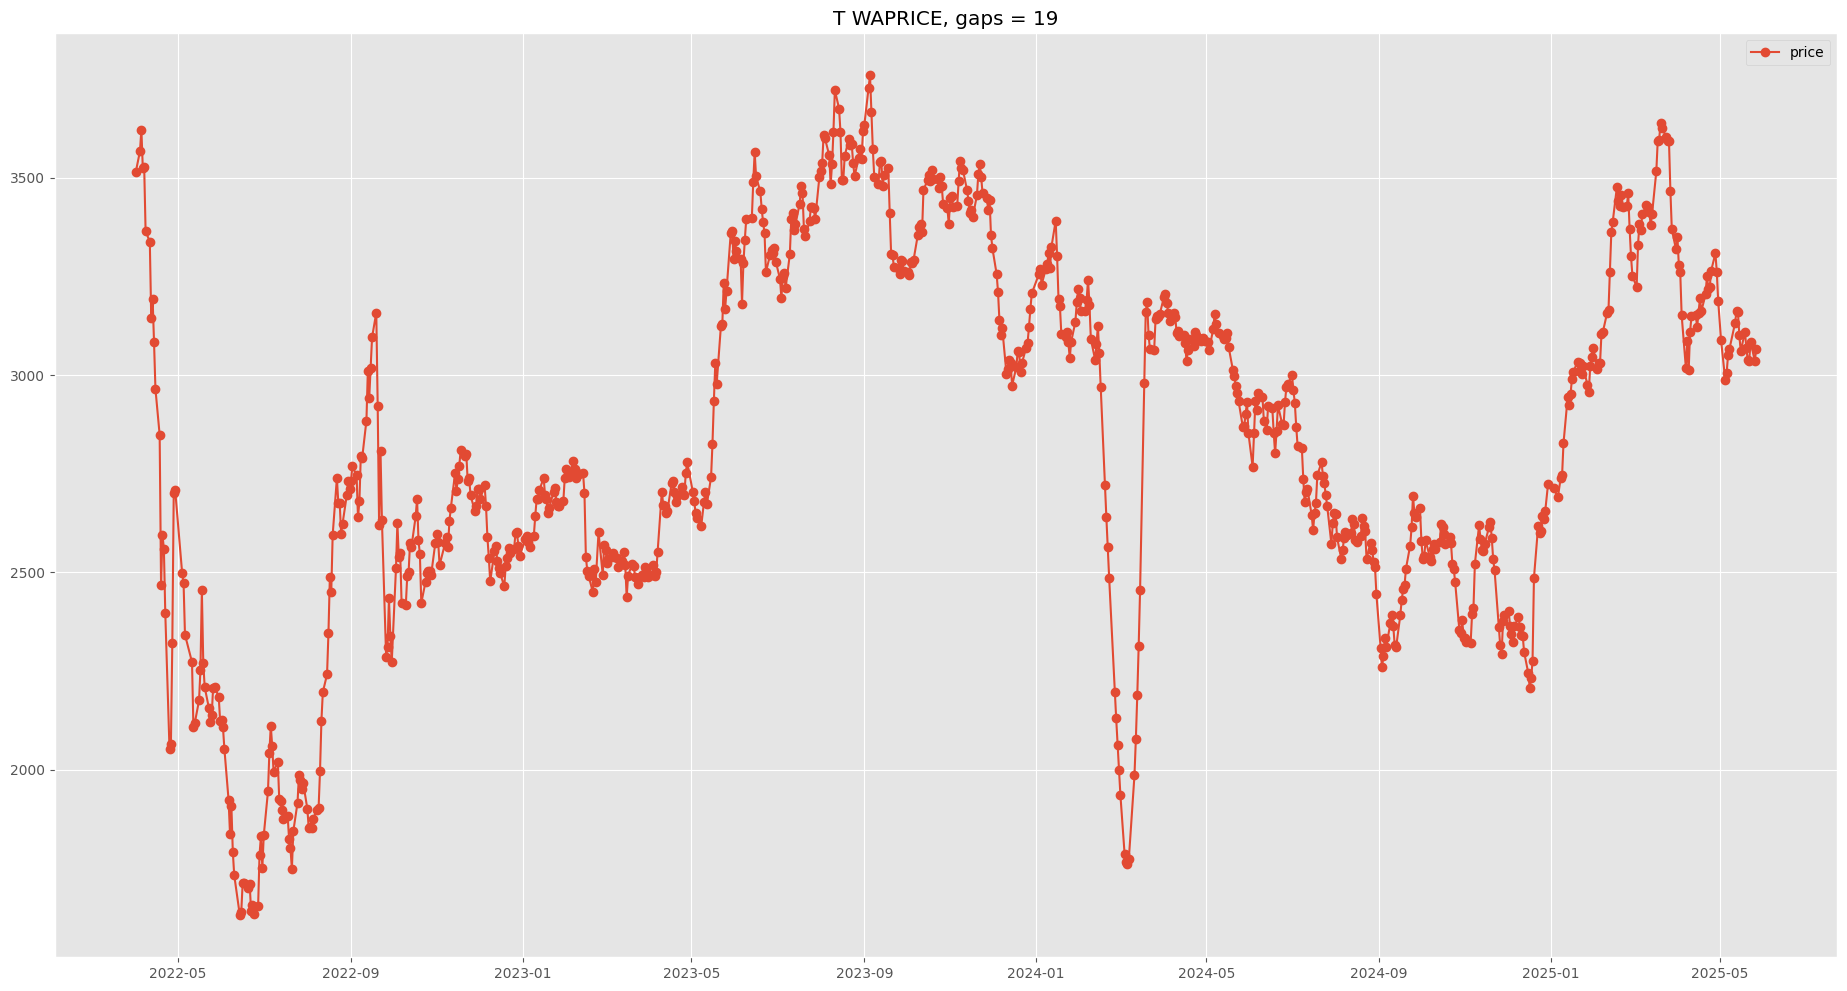

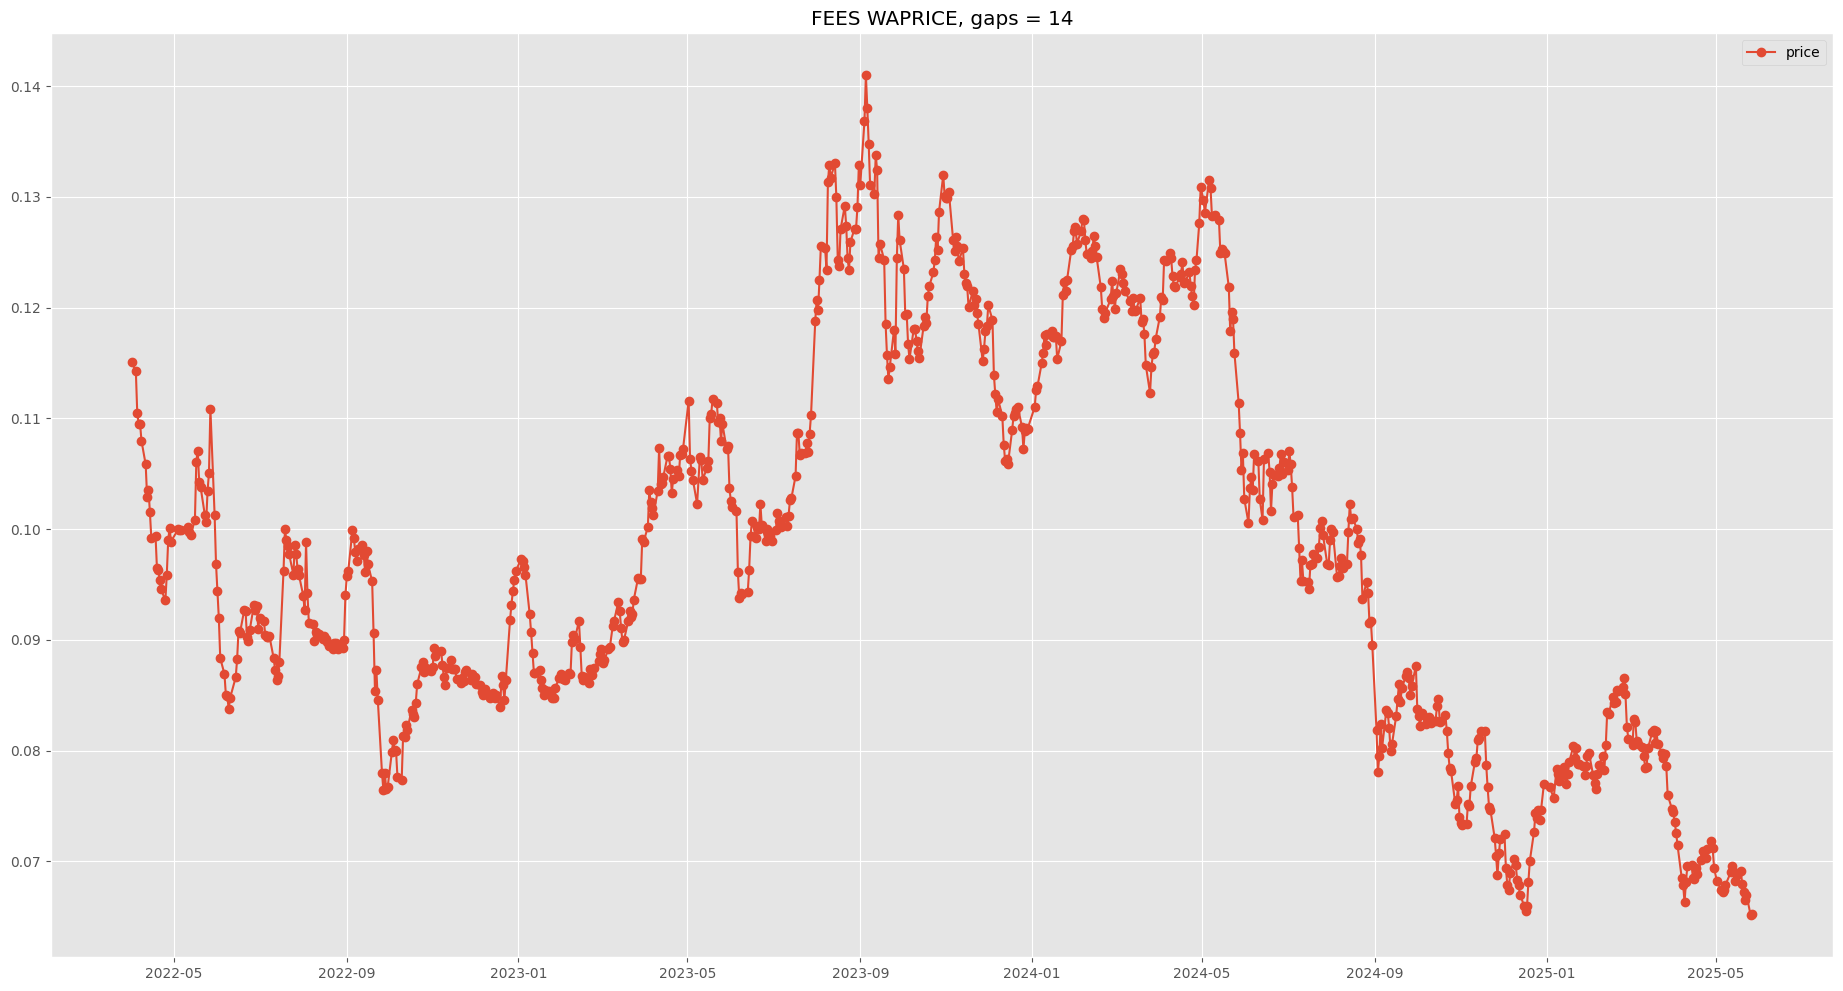

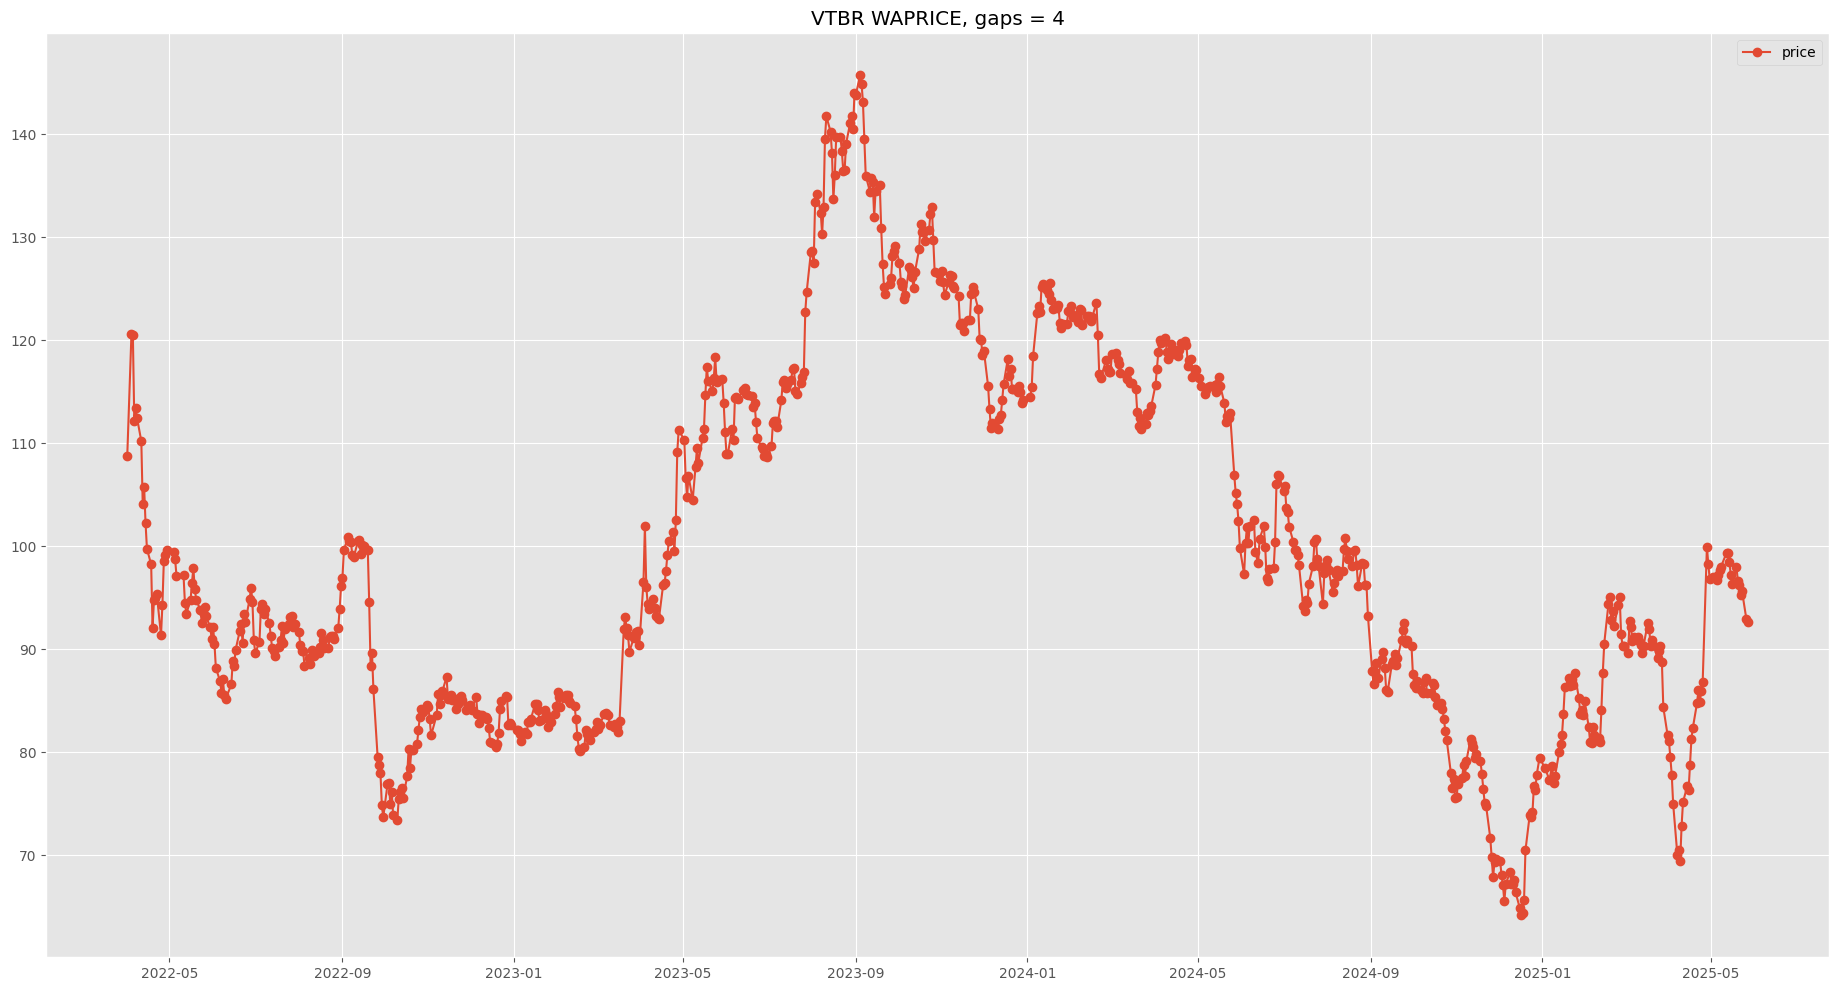

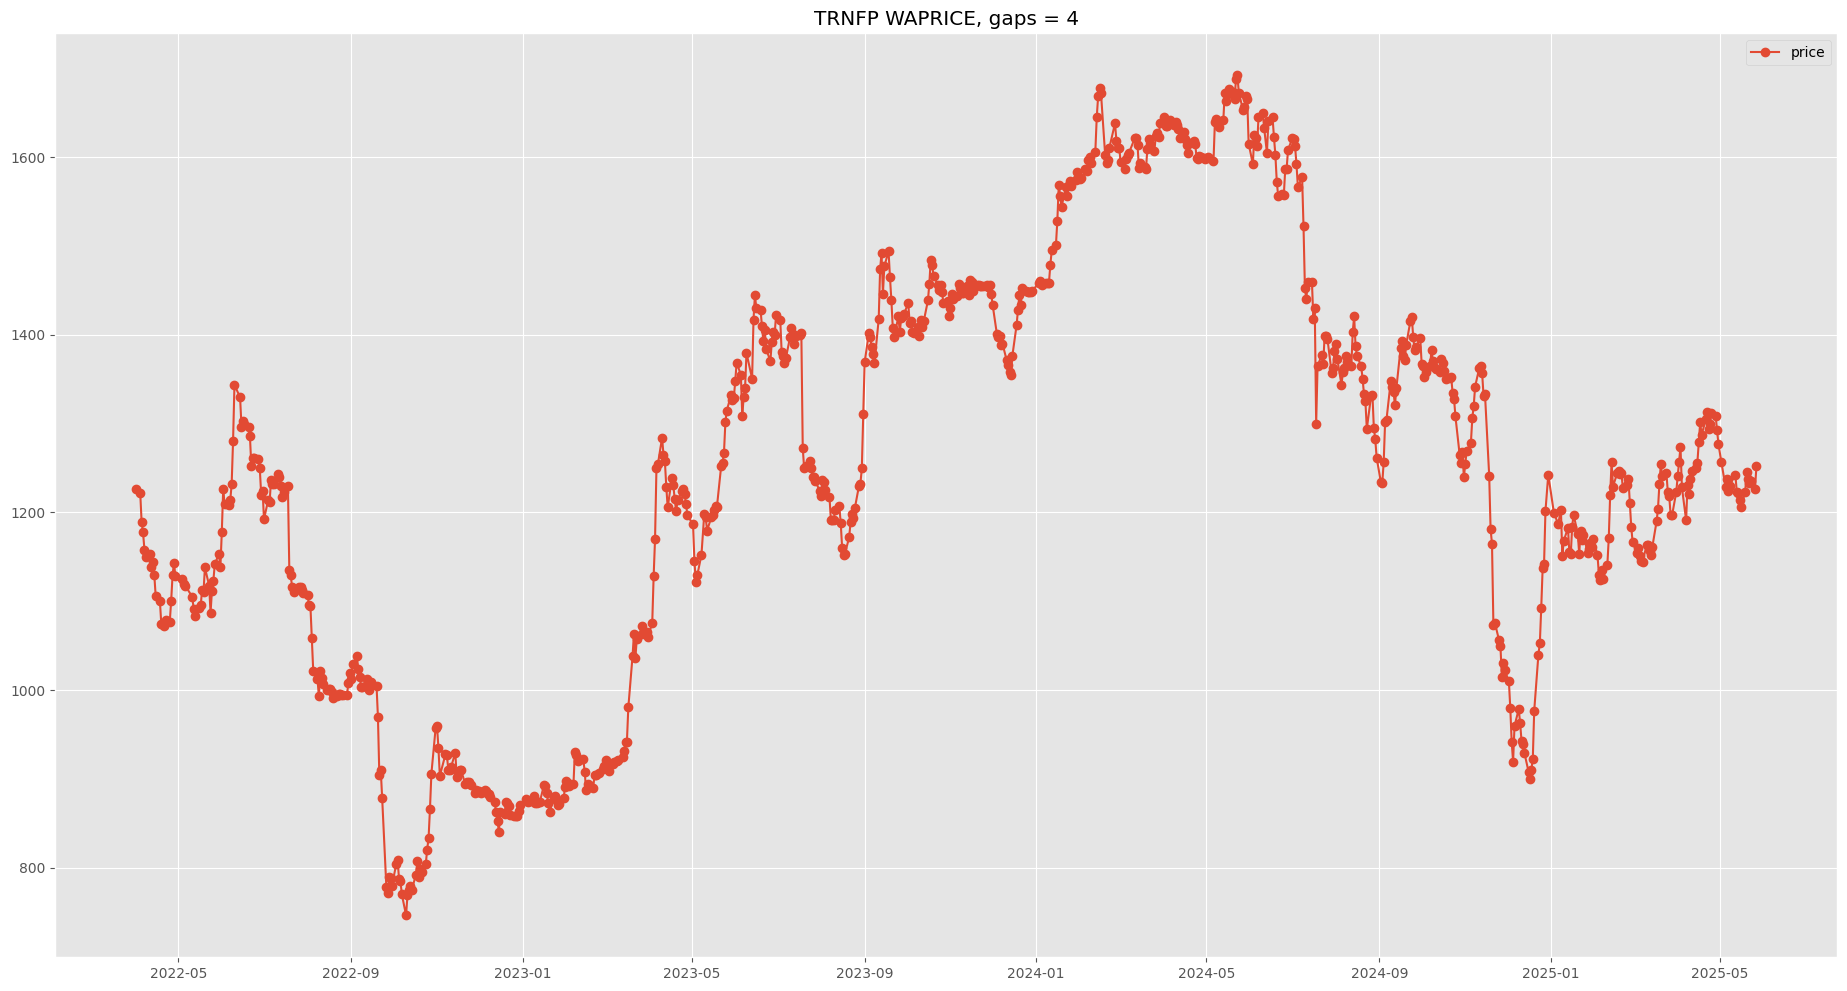

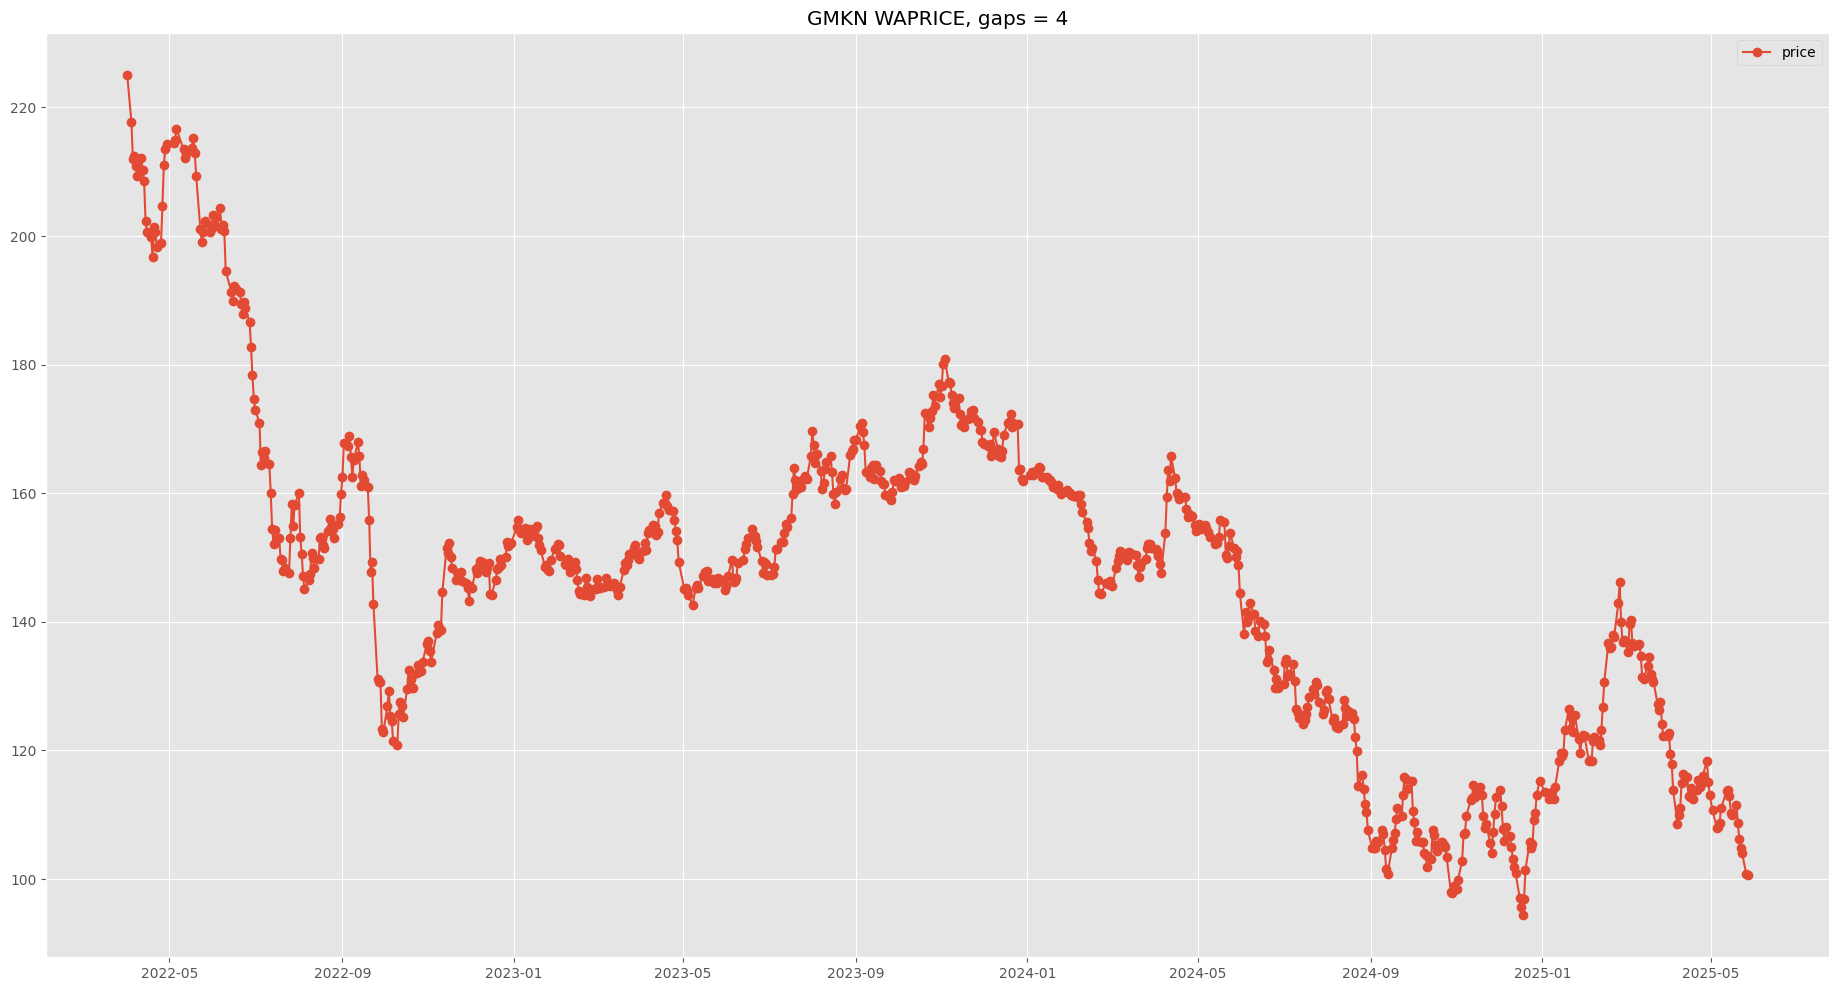

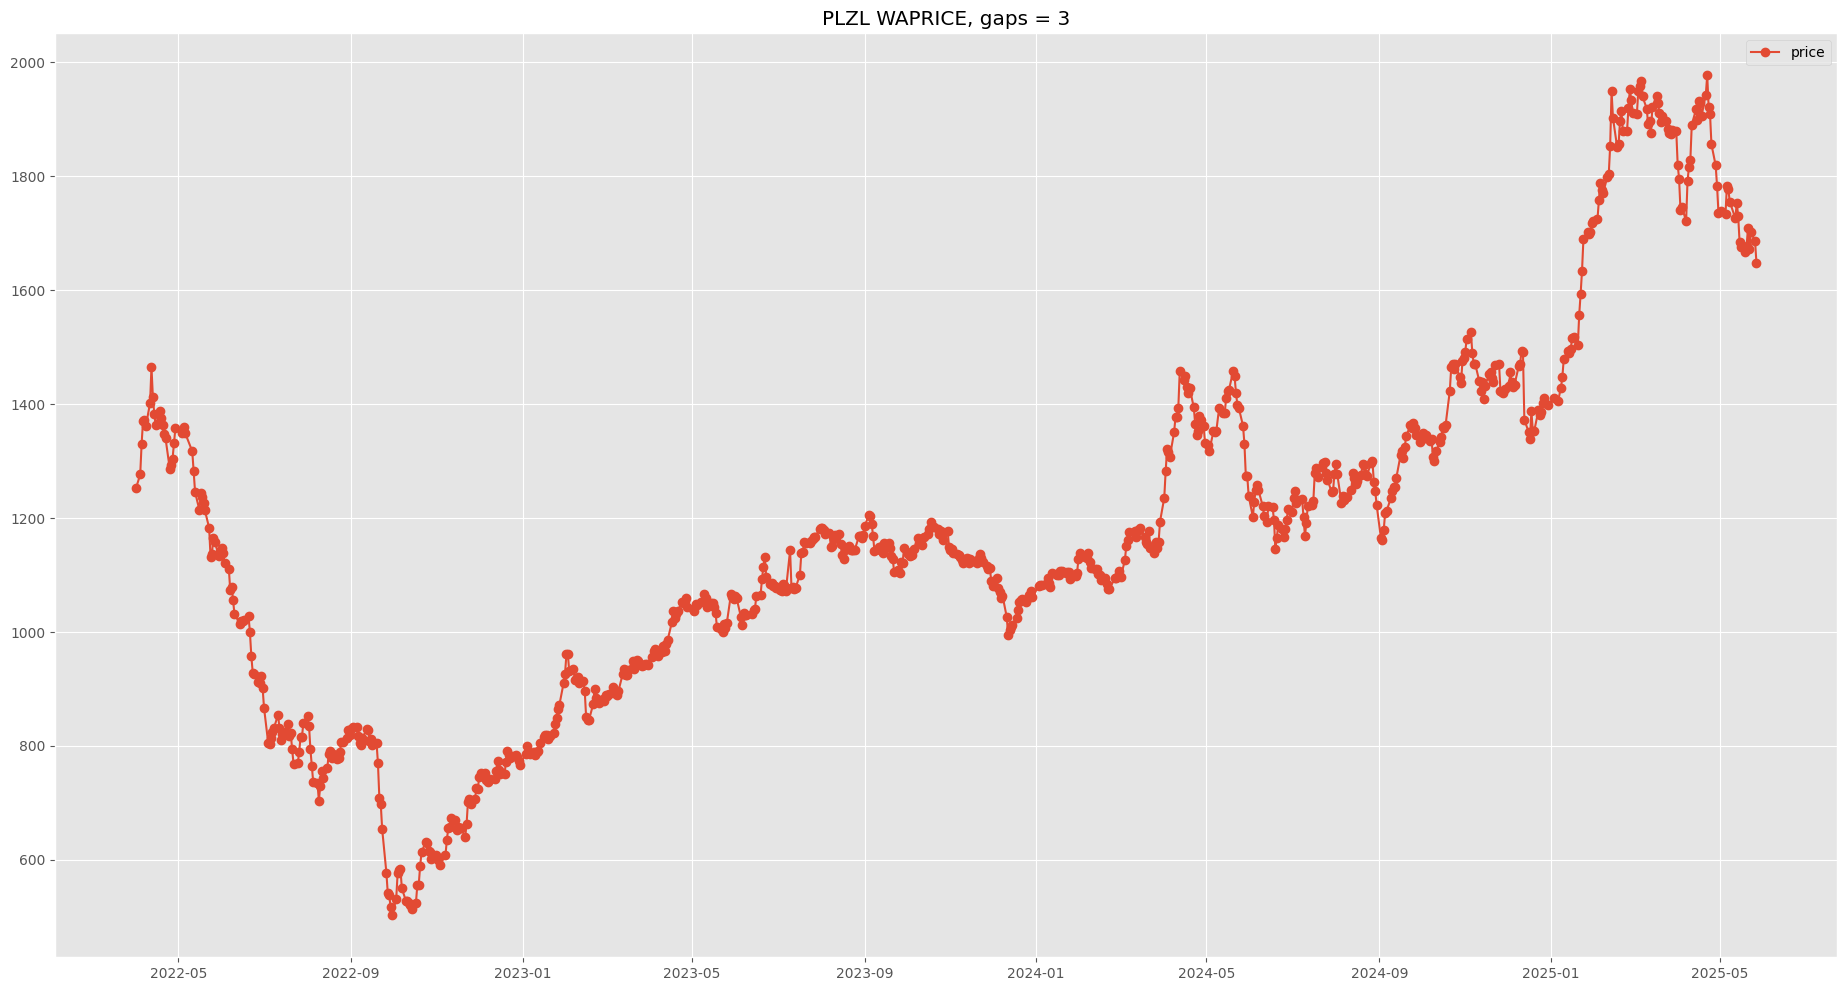

In [132]:
for ticker in list_of_tickers_with_gaps.index[list_of_tickers_with_gaps.values > 0]:
    plt.figure(figsize=(23, 12))

    plt.title(f'{ticker} WAPRICE, gaps = {list_of_tickers_with_gaps[ticker]}')

    plt.plot(df[df['SECID'] == ticker]['WAPRICE'], 
             marker='o',
             label='price')

    plt.legend()

In [133]:
df.isna().sum()

SECID      0
WAPRICE    0
OPEN       0
CLOSE      0
LOW        0
HIGH       0
VOLUME     0
dtype: int64

Пропусков больше нет

### Итоговый файл

In [134]:
df_final = df.reset_index().sort_values(by=['SECID', 'TRADEDATE'])
df_final['TRADEDATE'] = df_final['TRADEDATE'].astype(str)
df_final

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
0,2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
1,2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2,2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
3,2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
4,2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...,...
34395,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0
34396,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0
34397,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0
34398,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0


In [135]:
df_final.to_csv('data_after_preprocessing.csv', index=False)

### Сохраняем в БД

In [136]:
def update_clean_prices(df, db_path='moex_stock_price_prediction_service.db'):
    """
    Полностью перезаписывает таблицу clean_prices в базе данных.
    
    Параметры:
    df (pd.DataFrame): DataFrame с очищенными данными цен
    db_path (str): Путь к файлу базы данных
    """
    # Проверяем, что DataFrame имеет правильную структуру
    required_columns = ['SECID', 'TRADEDATE', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame должен содержать колонки: {required_columns}")
    
    # Подключаемся к базе данных
    with sqlite3.connect(db_path) as conn:
        # Если TRADEDATE является индексом, сбрасываем его в колонку
        if 'TRADEDATE' in df.index.names:
            df = df.reset_index()
        
        # Создаем таблицу (если не существует)
        cursor = conn.cursor()
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS clean_prices (
            SECID TEXT,
            TRADEDATE TEXT,
            WAPRICE REAL,
            OPEN REAL,
            CLOSE REAL,
            LOW REAL,
            HIGH REAL,
            VOLUME REAL,
            PRIMARY KEY (SECID, TRADEDATE)
        )
        ''')
        conn.commit()
        
        # Полностью перезаписываем таблицу
        df.to_sql('clean_prices', conn, if_exists='replace', index=False)
        
        # Оптимизация базы данных
        cursor.execute('VACUUM')
        conn.commit()

    print(f"✅ Таблица clean_prices успешно обновлена ({len(df)} записей)")

In [137]:
update_clean_prices(df_final, db_path='moex_stock_price_prediction_service.db')

✅ Таблица clean_prices успешно обновлена (35200 записей)


In [138]:
with sqlite3.connect('moex_stock_price_prediction_service.db') as conn:
    check = pd.read_sql('SELECT * FROM clean_prices', conn)
check

,TRADEDATE,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
0,2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
1,2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2,2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
3,2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
4,2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...,...
35195,2025-05-21,YDEX,4009.000,4042.000,3990.500,3971.000,4050.000,308142.0
35196,2025-05-22,YDEX,3997.500,3980.500,4024.000,3925.000,4089.000,773529.0
35197,2025-05-23,YDEX,4016.500,4029.500,4009.500,3996.000,4048.000,335528.0
35198,2025-05-26,YDEX,3934.000,4004.000,3917.000,3886.000,4024.000,505249.0
